In [31]:
%reset
import netCDF4
import numpy as np
import glob
import xarray as xr

import matplotlib.pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [33]:
grdfile = '/glade/derecho/scratch/eyankovsky/EASTPAC12p5KM/epac12p5km_grd.nc'
initfile =  '/glade/derecho/scratch/eyankovsky/EASTPAC12p5KM/epac12p5km_ini.nc'

grd = xr.open_dataset(grdfile)
dx = 1/grd.pm; dy = 1/grd.pn;
area=dx*dy

ALK = xr.open_dataset('/glade/derecho/scratch/eyankovsky/EASTPAC12p5KM/ALK_forcing.nc').ALK[1,:,:]
total_alk_Jan = np.nansum(ALK*31.0*86400*area)
total_alk_Apr = np.nansum(ALK*30.0*86400*area)
total_alk_Jul = np.nansum(ALK*31.0*86400*area)
total_alk_Oct = np.nansum(ALK*31.0*86400*area)
total_alk_1yr = np.nansum(ALK*365.0*86400*area)
total_alk_3yr = np.nansum(ALK*365.0*3*86400*area)

#Reading in January and Control:
infiles_Jan = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC12p5KM/EASTPAC12p5KM_Jan_data/eastpac12p5km_rst.*.nc')
infiles_Apr = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC12p5KM/EASTPAC12p5KM_Apr_data/eastpac12p5km_rst.*.nc')
infiles_Jul = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC12p5KM/EASTPAC12p5KM_Jul_data/eastpac12p5km_rst.*.nc')
infiles_Oct = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC12p5KM/EASTPAC12p5KM_Oct_data/eastpac12p5km_rst.*.nc')
infiles_1YR = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC12p5KM/EASTPAC12p5KM_1yr_data/eastpac12p5km_rst.*.nc')
infiles_3YR = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC12p5KM/EASTPAC12p5KM_5yr_data/eastpac12p5km_rst.*.nc')
infiles_ctl = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC12p5KM/EASTPAC12p5KM_Control_data/eastpac12p5km_rst.*.nc')

bgc_Jan = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC12p5KM/EASTPAC12p5KM_Jan_data/eastpac12p5km_bgc_dia_avg.*.nc')
bgc_Apr = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC12p5KM/EASTPAC12p5KM_Apr_data/eastpac12p5km_bgc_dia_avg.*.nc')
bgc_Jul = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC12p5KM/EASTPAC12p5KM_Jul_data/eastpac12p5km_bgc_dia_avg.*.nc')
bgc_Oct = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC12p5KM/EASTPAC12p5KM_Oct_data/eastpac12p5km_bgc_dia_avg.*.nc')
bgc_1YR = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC12p5KM/EASTPAC12p5KM_1yr_data/eastpac12p5km_bgc_dia_avg.*.nc')
bgc_3YR = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC12p5KM/EASTPAC12p5KM_5yr_data/eastpac12p5km_bgc_dia_avg.*.nc')
bgc_ctl = glob.glob('/glade/derecho/scratch/eyankovsky/EASTPAC12p5KM/EASTPAC12p5KM_Control_data/eastpac12p5km_bgc_dia_avg.*.nc')

infiles_Jan.sort(); infiles_Apr.sort(); infiles_Jul.sort(); infiles_Oct.sort(); infiles_1YR.sort(); infiles_3YR.sort(); infiles_ctl.sort(); 
bgc_Jan.sort(); bgc_Apr.sort(); bgc_Jul.sort(); bgc_Oct.sort(); bgc_1YR.sort(); bgc_3YR.sort(); bgc_ctl.sort();
print('done')

done


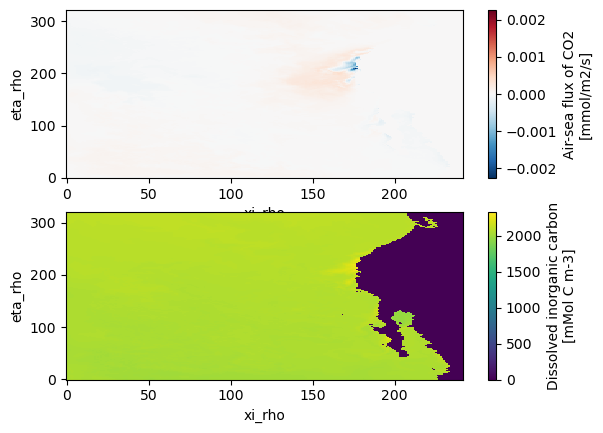

In [34]:
ii = 33
#Jan 33; Apr 33; Jul 33; Oct 33; 1YR 33; Ctl 
test1=xr.open_dataset(bgc_ctl[ii])['FG_CO2']
test2=xr.open_dataset(infiles_ctl[ii])['DIC'][0,-1,:,:]

plt.subplot(2,1,1)
test1.plot()
plt.subplot(2,1,2)
test2.plot()

In [35]:
def Cs(sigma, theta_s, theta_b):
    C = ( 1 - np.cosh(theta_s * sigma) ) / (np.cosh(theta_s) - 1)
    C = (np.exp(theta_b * C) - 1) / (1 - np.exp(-theta_b))
    return C

def get_thickness(zeta, h):
    
    N = 100
    theta_s = 6
    theta_b = 6
    hc = 250

    k_w = np.linspace(0,N,N+1)

    sigma_w = (k_w - N) / N

    Cs_w = Cs(sigma_w, theta_s, theta_b)

    S_w = np.zeros((N+1, h.shape[0], h.shape[1]))

    for k in range(N+1):
        S_w[k,:,:] = (hc * sigma_w[k] + h*Cs_w[k]) / (hc + h)
                
    z_w = np.zeros((N+1, h.shape[0], h.shape[1]))
    for k in range(N+1):
        z_w[k,:,:] = zeta + (zeta + h)*S_w[k,:,:]

    H = np.diff(z_w,axis=0)
    
    return H

In [36]:
len(bgc_Jan)

648

In [37]:
#ALK_forced = np.zeros([len(infiles),dx.shape[0],dx.shape[1]])
#ALK_unforced = np.zeros([len(infiles),dx.shape[0],dx.shape[1]])
h = xr.open_dataset(grdfile)['h'][:,:]

time = np.zeros(len(infiles_ctl))
fraction_Jan = np.zeros(len(infiles_ctl))
# fraction_1yr = np.zeros(len(infiles_ctl))
# fraction_3yr = np.zeros(len(infiles_ctl))

ALK_diff_Jan = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])
DIC_diff_Jan = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])
flux_diff_Jan = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])

ALK_diff_Apr = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])
DIC_diff_Apr = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])
flux_diff_Apr = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])

ALK_diff_Jul = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])
DIC_diff_Jul = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])
flux_diff_Jul = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])

ALK_diff_Oct = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])
DIC_diff_Oct = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])
flux_diff_Oct = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])

ALK_diff_1yr = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])
DIC_diff_1yr = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])
flux_diff_1yr = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])

ALK_diff_3yr = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])
DIC_diff_3yr = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])
flux_diff_3yr = np.zeros([len(infiles_ctl),dx.shape[0],dx.shape[1]])



In [38]:
for index in range(len(bgc_Jan)): #range(len(infiles)):
    print(index)
    ALK_forced_Jan = xr.open_dataset(infiles_Jan[index])['Alk'][1,:,:,:]
    DIC_forced_Jan = xr.open_dataset(infiles_Jan[index])['DIC'][1,:,:,:]
    flux_Jan = xr.open_dataset(bgc_Jan[index])['FG_CO2'][0,:,:]

    ALK_forced_Apr = xr.open_dataset(infiles_Apr[index])['Alk'][1,:,:,:]
    DIC_forced_Apr = xr.open_dataset(infiles_Apr[index])['DIC'][1,:,:,:]
    flux_Apr = xr.open_dataset(bgc_Apr[index])['FG_CO2'][0,:,:]

    ALK_forced_Jul = xr.open_dataset(infiles_Jul[index])['Alk'][1,:,:,:]
    DIC_forced_Jul = xr.open_dataset(infiles_Jul[index])['DIC'][1,:,:,:]
    flux_Jul = xr.open_dataset(bgc_Jul[index])['FG_CO2'][0,:,:]

    ALK_forced_Oct = xr.open_dataset(infiles_Oct[index])['Alk'][1,:,:,:]
    DIC_forced_Oct = xr.open_dataset(infiles_Oct[index])['DIC'][1,:,:,:]
    flux_Oct = xr.open_dataset(bgc_Oct[index])['FG_CO2'][0,:,:]

    ALK_forced_1yr = xr.open_dataset(infiles_1YR[index])['Alk'][1,:,:,:]
    DIC_forced_1yr = xr.open_dataset(infiles_1YR[index])['DIC'][1,:,:,:]
    flux_1yr = xr.open_dataset(bgc_1YR[index])['FG_CO2'][0,:,:]

    ALK_forced_3yr = xr.open_dataset(infiles_3YR[index])['Alk'][1,:,:,:]
    DIC_forced_3yr = xr.open_dataset(infiles_3YR[index])['DIC'][1,:,:,:]
    flux_3yr = xr.open_dataset(bgc_3YR[index])['FG_CO2'][0,:,:]

    ALK_unforced = xr.open_dataset(infiles_ctl[index])['Alk'][1,:,:,:]
    DIC_unforced = xr.open_dataset(infiles_ctl[index])['DIC'][1,:,:,:]
    flux_unforced = xr.open_dataset(bgc_ctl[index])['FG_CO2'][0,:,:]
    
    SSH = xr.open_dataset(infiles_ctl[index])['zeta'][1,:,:]
    H = get_thickness(SSH,h)
    
    ALK_forced_ws_Jan = (ALK_forced_Jan*H).sum(axis=0)*area     #mMol
    ALK_forced_ws_Apr = (ALK_forced_Apr*H).sum(axis=0)*area     #mMol
    ALK_forced_ws_Jul = (ALK_forced_Jul*H).sum(axis=0)*area     #mMol
    ALK_forced_ws_Oct = (ALK_forced_Oct*H).sum(axis=0)*area     #mMol
    ALK_forced_ws_1yr = (ALK_forced_1yr*H).sum(axis=0)*area     #mMol
    ALK_forced_ws_3yr = (ALK_forced_3yr*H).sum(axis=0)*area     #mMol
    ALK_unforced_ws = (ALK_unforced*H).sum(axis=0)*area #mMol    
    
    ALK_diff_Jan[index] = ALK_forced_ws_Jan-ALK_unforced_ws
    ALK_diff_Apr[index] = ALK_forced_ws_Apr-ALK_unforced_ws
    ALK_diff_Jul[index] = ALK_forced_ws_Jul-ALK_unforced_ws
    ALK_diff_Oct[index] = ALK_forced_ws_Oct-ALK_unforced_ws
    ALK_diff_1yr[index] = ALK_forced_ws_1yr-ALK_unforced_ws
    ALK_diff_3yr[index] = ALK_forced_ws_3yr-ALK_unforced_ws

    DIC_forced_ws_Jan = (DIC_forced_Jan*H).sum(axis=0)*area     #mMol
    DIC_forced_ws_Apr = (DIC_forced_Apr*H).sum(axis=0)*area     #mMol
    DIC_forced_ws_Jul = (DIC_forced_Jul*H).sum(axis=0)*area     #mMol
    DIC_forced_ws_Oct = (DIC_forced_Oct*H).sum(axis=0)*area     #mMol
    DIC_forced_ws_1yr = (DIC_forced_1yr*H).sum(axis=0)*area     #mMol
    DIC_forced_ws_3yr = (DIC_forced_3yr*H).sum(axis=0)*area     #mMol
    DIC_unforced_ws = (DIC_unforced*H).sum(axis=0)*area #mMol
    
    DIC_diff_Jan[index] = DIC_forced_ws_Jan-DIC_unforced_ws
    DIC_diff_Apr[index] = DIC_forced_ws_Apr-DIC_unforced_ws
    DIC_diff_Jul[index] = DIC_forced_ws_Jul-DIC_unforced_ws
    DIC_diff_Oct[index] = DIC_forced_ws_Oct-DIC_unforced_ws
    DIC_diff_1yr[index] = DIC_forced_ws_1yr-DIC_unforced_ws
    DIC_diff_3yr[index] = DIC_forced_ws_3yr-DIC_unforced_ws

    flux_diff_Jan[index] = flux_Jan-flux_unforced
    flux_diff_Apr[index] = flux_Apr-flux_unforced
    flux_diff_Jul[index] = flux_Jul-flux_unforced
    flux_diff_Oct[index] = flux_Oct-flux_unforced
    flux_diff_1yr[index] = flux_1yr-flux_unforced
    flux_diff_3yr[index] = flux_3yr-flux_unforced

    time[index] = xr.open_dataset(infiles_ctl[index])['ocean_time'][1]


    fraction_Jan[index] = np.nansum(ALK_diff_Jan[index])/total_alk_Jan


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [39]:
integrated_ALK = np.zeros(len(infiles_ctl))
integrated_DIC = np.zeros(len(infiles_ctl))
for index in range(len(bgc_ctl)): #range(len(infiles)):

    ALK_unforced = xr.open_dataset(infiles_ctl[index])['Alk'][1,:,:,:]
    DIC_unforced = xr.open_dataset(infiles_ctl[index])['DIC'][1,:,:,:]
    
    SSH = xr.open_dataset(infiles_ctl[index])['zeta'][1,:,:]
    H = get_thickness(SSH,h)
    integrated_ALK[index] = np.nansum((ALK_unforced*H).sum(axis=0)*area) #mMol    
    integrated_DIC[index] = np.nansum((DIC_unforced*H).sum(axis=0)*area) #mMol    
    
    print(index)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

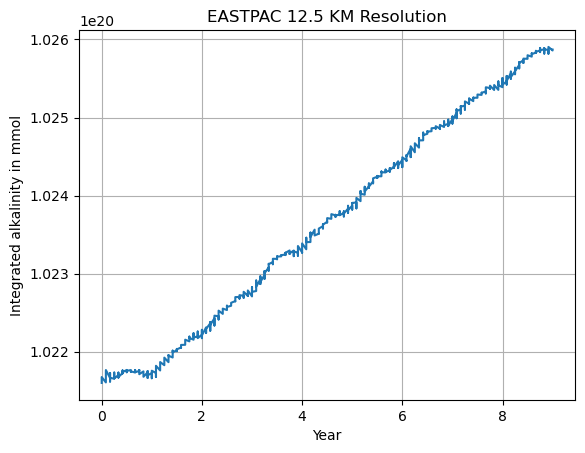

In [40]:
plt.plot(np.round(((time/86400)-731)/30.5)/12,integrated_ALK)
plt.xlabel('Year')
plt.ylabel('Integrated alkalinity in mmol')
plt.title('EASTPAC 12.5 KM Resolution')
plt.grid()

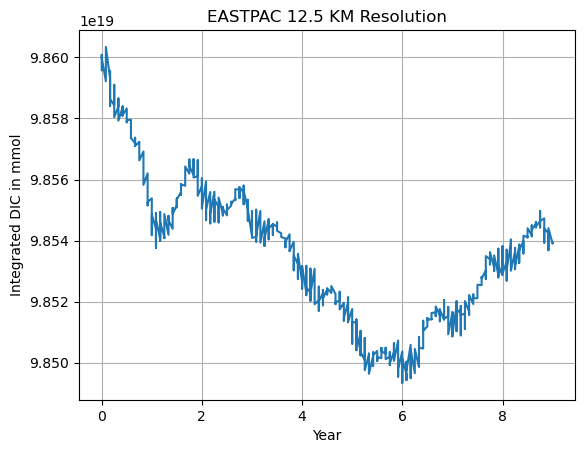

In [41]:
plt.plot(np.round(((time/86400)-731)/30.5)/12,integrated_DIC)
plt.xlabel('Year')
plt.ylabel('Integrated DIC in mmol')
plt.title('EASTPAC 12.5 KM Resolution')
plt.grid()

Text(0, 0.5, 'Fraction')

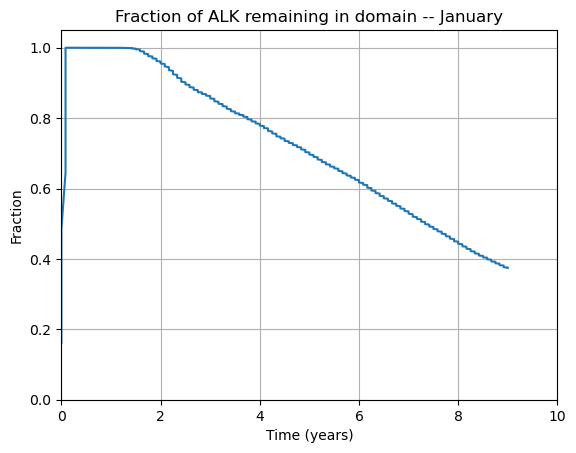

In [42]:
plt.plot(np.round(((time/86400)-731)/30.5)/12,fraction_Jan)
plt.title('Fraction of ALK remaining in domain -- January')
plt.grid(); plt.xlim([0,10]); plt.ylim([0,1.05]);
plt.xlabel('Time (years)'); plt.ylabel('Fraction')

Text(0, 0.5, '$\\eta$')

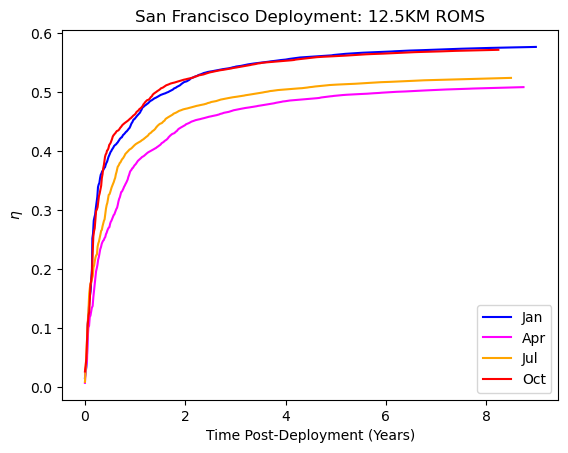

In [43]:
plt.plot((time-time[0])/86400/365,np.cumsum(np.nansum(np.nansum(flux_diff_Jan[0:]*86400*5*area.values,axis=1),axis=1))/total_alk_Jan,label='Jan',color='blue')
plt.plot((time[18:]-time[18])/86400/365,np.cumsum(np.nansum(np.nansum(flux_diff_Apr[18:]*86400*5*area.values,axis=1),axis=1))/total_alk_Apr,label='Apr',color='fuchsia')
plt.plot((time[36:]-time[36])/86400/365,np.cumsum(np.nansum(np.nansum(flux_diff_Jul[36:]*86400*5*area.values,axis=1),axis=1))/total_alk_Jul,label='Jul',color='orange')
plt.plot((time[54:]-time[54])/86400/365,np.cumsum(np.nansum(np.nansum(flux_diff_Oct[54:]*86400*5*area.values,axis=1),axis=1))/total_alk_Oct,label='Oct',color='red')
plt.legend()
plt.title('San Francisco Deployment: 12.5KM ROMS')
#plt.grid(); plt.xlim([0,9]); plt.ylim([0,0.8]);
plt.xlabel('Time Post-Deployment (Years)'); plt.ylabel('$\eta$')

In [44]:
f1 = ([ 0.        ,  0.07671233,  0.16164384,  0.24383562,  0.32876712,
        0.4109589 ,  0.49589041,  0.58082192,  0.6630137 ,  0.74794521,
        0.83013699,  0.91506849,  1.        ,  1.07671233,  1.16164384,
        1.24383562,  1.32876712,  1.4109589 ,  1.49589041,  1.58082192,
        1.6630137 ,  1.74794521,  1.83013699,  1.91506849,  2.        ,
        2.07671233,  2.16164384,  2.24383562,  2.32876712,  2.4109589 ,
        2.49589041,  2.58082192,  2.6630137 ,  2.74794521,  2.83013699,
        2.91506849,  3.        ,  3.07945205,  3.16438356,  3.24657534,
        3.33150685,  3.41369863,  3.49863014,  3.58356164,  3.66575342,
        3.75068493,  3.83287671,  3.91780822,  4.00273973,  4.07945205,
        4.16438356,  4.24657534,  4.33150685,  4.41369863,  4.49863014,
        4.58356164,  4.66575342,  4.75068493,  4.83287671,  4.91780822,
        5.00273973,  5.07945205,  5.16438356,  5.24657534,  5.33150685,
        5.41369863,  5.49863014,  5.58356164,  5.66575342,  5.75068493,
        5.83287671,  5.91780822,  6.00273973,  6.07945205,  6.16438356,
        6.24657534,  6.33150685,  6.41369863,  6.49863014,  6.58356164,
        6.66575342,  6.75068493,  6.83287671,  6.91780822,  7.00273973,
        7.08219178,  7.16712329,  7.24931507,  7.33424658,  7.41643836,
        7.50136986,  7.58630137,  7.66849315,  7.75342466,  7.83561644,
        7.92054795,  8.00547945,  8.08219178,  8.16712329,  8.24931507,
        8.33424658,  8.41643836,  8.50136986,  8.58630137,  8.66849315,
        8.75342466,  8.83561644,  8.92054795,  9.00547945,  9.08219178,
        9.16712329,  9.24931507,  9.33424658,  9.41643836,  9.50136986,
        9.58630137,  9.66849315,  9.75342466,  9.83561644,  9.92054795,
       10.00547945, 10.08219178, 10.16712329, 10.24931507, 10.33424658,
       10.41643836, 10.50136986, 10.58630137, 10.66849315, 10.75342466,
       10.83561644, 10.92054795, 11.00547945, 11.08493151, 11.16986301,
       11.25205479, 11.3369863 , 11.41917808, 11.50410959, 11.5890411 ,
       11.67123288, 11.75616438, 11.83835616, 11.92328767, 12.00821918,
       12.08493151, 12.16986301, 12.25205479, 12.3369863 , 12.41917808,
       12.50410959, 12.5890411 , 12.67123288, 12.75616438, 12.83835616,
       12.92328767, 13.00821918, 13.08493151, 13.16986301, 13.25205479,
       13.3369863 , 13.41917808, 13.50410959, 13.5890411 , 13.67123288,
       13.75616438, 13.83835616, 13.92328767, 14.00821918, 14.08493151,
       14.16986301, 14.25205479, 14.3369863 , 14.41917808, 14.50410959,
       14.5890411 , 14.67123288, 14.75616438, 14.83835616, 14.92328767]);
f2 = ([0.11340775, 0.47448181, 0.54537792, 0.5916384 , 0.59916223,
       0.61399415, 0.62812014, 0.63517443, 0.63748771, 0.64881271,
       0.66120365, 0.66404706, 0.67191278, 0.6811698 , 0.68698961,
       0.69003914, 0.69297133, 0.69714208, 0.70017353, 0.70273582,
       0.70549448, 0.70909482, 0.71184959, 0.71472596, 0.71788161,
       0.71999317, 0.72338593, 0.72588817, 0.72743996, 0.72815443,
       0.72927124, 0.73056192, 0.73109946, 0.73190387, 0.73291931,
       0.73414473, 0.73497997, 0.73605407, 0.73722474, 0.73826691,
       0.73927488, 0.73975178, 0.74020305, 0.74060904, 0.74114594,
       0.74198643, 0.7425257 , 0.74290876, 0.74376534, 0.74426571,
       0.74460703, 0.74529475, 0.74552114, 0.74588613, 0.74619166,
       0.74641353, 0.74672182, 0.7469458 , 0.74712647, 0.74743643,
       0.7482358 , 0.74848828, 0.74878817, 0.74916746, 0.7493556 ,
       0.74957665, 0.74968161, 0.74983089, 0.74996877, 0.75003659,
       0.75014286, 0.75041177, 0.7505598 , 0.75073556, 0.75084913,
       0.75107841, 0.75123399, 0.75134296, 0.75141775, 0.75157404,
       0.75168999, 0.75176841, 0.75188625, 0.75206709, 0.7523186 ,
       0.75253077, 0.75269802, 0.75276956, 0.75288167, 0.75297892,
       0.75306375, 0.75311724, 0.75319586, 0.75337478, 0.75360167,
       0.75369005, 0.75386983, 0.75393766, 0.75403836, 0.75411617,
       0.75419785, 0.75426337, 0.75431744, 0.75436306, 0.75442076,
       0.75451178, 0.7546053 , 0.75466764, 0.75478518, 0.75485007,
       0.75488309, 0.75495174, 0.75500836, 0.75504993, 0.75507935,
       0.75511725, 0.75514876, 0.75519466, 0.75528786, 0.75536901,
       0.75541946, 0.7555442 , 0.75559255, 0.75562169, 0.75565952,
       0.75569739, 0.755727  , 0.75575178, 0.75578015, 0.75582392,
       0.75587198, 0.75593745, 0.75602224, 0.75605357, 0.75610787,
       0.75617961, 0.75621462, 0.75624074, 0.75625827, 0.75628639,
       0.75630452, 0.75632351, 0.7563469 , 0.75638425, 0.75641245,
       0.75644193, 0.75648497, 0.75652312, 0.75653684, 0.75654998,
       0.7565628 , 0.75657513, 0.75660843, 0.75663462, 0.75666074,
       0.75669641, 0.75671335, 0.75673656, 0.75675876, 0.75681798,
       0.75683577, 0.75685897, 0.75687352, 0.75689081, 0.75689874,
       0.75691252, 0.75694334, 0.756967  , 0.75699442, 0.75701316,
       0.7570295 , 0.75706884, 0.75708664, 0.75710013, 0.75710985,
       0.75712768, 0.75713544, 0.75715095, 0.75717317, 0.75718987]);
f3 = ([ 0.        ,  0.08493151,  0.16712329,  0.25205479,  0.3369863 ,
        0.41917808,  0.50410959,  0.58630137,  0.67123288,  0.75616438,
        0.83287671,  0.91780822,  1.        ,  1.08493151,  1.16712329,
        1.25205479,  1.3369863 ,  1.41917808,  1.50410959,  1.58630137,
        1.67123288,  1.75616438,  1.83287671,  1.91780822,  2.        ,
        2.08493151,  2.16712329,  2.25205479,  2.3369863 ,  2.41917808,
        2.50410959,  2.58630137,  2.67123288,  2.75616438,  2.83561644,
        2.92054795,  3.00273973,  3.08767123,  3.16986301,  3.25479452,
        3.33972603,  3.42191781,  3.50684932,  3.5890411 ,  3.6739726 ,
        3.75890411,  3.83561644,  3.92054795,  4.00273973,  4.08767123,
        4.16986301,  4.25479452,  4.33972603,  4.42191781,  4.50684932,
        4.5890411 ,  4.6739726 ,  4.75890411,  4.83561644,  4.92054795,
        5.00273973,  5.08767123,  5.16986301,  5.25479452,  5.33972603,
        5.42191781,  5.50684932,  5.5890411 ,  5.6739726 ,  5.75890411,
        5.83561644,  5.92054795,  6.00273973,  6.08767123,  6.16986301,
        6.25479452,  6.33972603,  6.42191781,  6.50684932,  6.5890411 ,
        6.6739726 ,  6.75890411,  6.83835616,  6.92328767,  7.00547945,
        7.09041096,  7.17260274,  7.25753425,  7.34246575,  7.42465753,
        7.50958904,  7.59178082,  7.67671233,  7.76164384,  7.83835616,
        7.92328767,  8.00547945,  8.09041096,  8.17260274,  8.25753425,
        8.34246575,  8.42465753,  8.50958904,  8.59178082,  8.67671233,
        8.76164384,  8.83835616,  8.92328767,  9.00547945,  9.09041096,
        9.17260274,  9.25753425,  9.34246575,  9.42465753,  9.50958904,
        9.59178082,  9.67671233,  9.76164384,  9.83835616,  9.92328767,
       10.00547945, 10.09041096, 10.17260274, 10.25753425, 10.34246575,
       10.42465753, 10.50958904, 10.59178082, 10.67671233, 10.76164384,
       10.84109589, 10.9260274 , 11.00821918, 11.09315068, 11.17534247,
       11.26027397, 11.34520548, 11.42739726, 11.51232877, 11.59452055,
       11.67945205, 11.76438356, 11.84109589, 11.9260274 , 12.00821918,
       12.09315068, 12.17534247, 12.26027397, 12.34520548, 12.42739726,
       12.51232877, 12.59452055, 12.67945205, 12.76438356, 12.84109589,
       12.9260274 , 13.00821918, 13.09315068, 13.17534247, 13.26027397,
       13.34520548, 13.42739726, 13.51232877, 13.59452055, 13.67945205,
       13.76438356, 13.84109589, 13.9260274 , 14.00821918, 14.09315068,
       14.17534247, 14.26027397, 14.34520548, 14.42739726, 14.51232877,
       14.59452055, 14.67945205]);
f4 = ([0.17801645, 0.20675004, 0.23908056, 0.26815802, 0.2821365 ,
       0.28626742, 0.30528413, 0.32784682, 0.33252173, 0.34493082,
       0.35953353, 0.36909193, 0.37378568, 0.37842487, 0.3850523 ,
       0.38994151, 0.39400192, 0.39839605, 0.40391886, 0.40803655,
       0.41229212, 0.41689554, 0.41999712, 0.42494711, 0.42860813,
       0.43087305, 0.43194816, 0.43366246, 0.4355557 , 0.43636976,
       0.43751639, 0.43896366, 0.44068174, 0.44188964, 0.44342532,
       0.44509723, 0.44660835, 0.44809112, 0.44879664, 0.44945332,
       0.45005945, 0.45084682, 0.45205053, 0.45281542, 0.45334452,
       0.45452844, 0.45521796, 0.45569303, 0.45665895, 0.45698535,
       0.45752082, 0.45796644, 0.45828716, 0.45874182, 0.45906095,
       0.45931383, 0.45974366, 0.46085194, 0.46120152, 0.46162135,
       0.46215848, 0.46242557, 0.46273851, 0.4628905 , 0.46310396,
       0.46330265, 0.46339964, 0.46354705, 0.4639209 , 0.46412584,
       0.46437075, 0.46452779, 0.46484978, 0.46506903, 0.46522365,
       0.46533126, 0.46555231, 0.46571715, 0.46582529, 0.4659857 ,
       0.46623124, 0.46657417, 0.46686633, 0.46709512, 0.46719524,
       0.46735188, 0.46748912, 0.46760913, 0.46768458, 0.46779582,
       0.46804439, 0.46835665, 0.46847725, 0.46872285, 0.46881661,
       0.46895498, 0.46906375, 0.46917767, 0.4692692 , 0.46934554,
       0.46940904, 0.46948941, 0.46961522, 0.46974324, 0.46982796,
       0.46998701, 0.47007464, 0.47011976, 0.47021355, 0.47029158,
       0.47034991, 0.47039139, 0.47044412, 0.47048825, 0.47055154,
       0.47067881, 0.47078836, 0.47085618, 0.471024  , 0.47108982,
       0.47112959, 0.4711821 , 0.47123484, 0.47127627, 0.47131144,
       0.47135134, 0.47141185, 0.47147692, 0.47156462, 0.47167853,
       0.47172087, 0.47179432, 0.47189129, 0.47193979, 0.47197647,
       0.47200112, 0.47203992, 0.47206532, 0.4720916 , 0.47212374,
       0.472174  , 0.47221177, 0.47225156, 0.47230922, 0.47236088,
       0.47237997, 0.47239815, 0.47241626, 0.47243362, 0.47248033,
       0.47251615, 0.47255168, 0.47259984, 0.47262274, 0.47265409,
       0.47268424, 0.47276391, 0.47278825, 0.47281993, 0.47284021,
       0.47286435, 0.47287553, 0.47289468, 0.47293662, 0.47296842,
       0.47300546, 0.47303055, 0.47305259, 0.47310566, 0.47312979,
       0.47314848, 0.47316202, 0.47318653, 0.47319743, 0.47321874,
       0.47324868, 0.473271  ]);
f5 = ([ 0.        ,  0.08493151,  0.16712329,  0.25205479,  0.33424658,
        0.41917808,  0.50410959,  0.58082192,  0.66575342,  0.74794521,
        0.83287671,  0.91506849,  1.        ,  1.08493151,  1.16712329,
        1.25205479,  1.33424658,  1.41917808,  1.50410959,  1.58082192,
        1.66575342,  1.74794521,  1.83287671,  1.91506849,  2.        ,
        2.08493151,  2.16712329,  2.25205479,  2.33424658,  2.41917808,
        2.50410959,  2.58356164,  2.66849315,  2.75068493,  2.83561644,
        2.91780822,  3.00273973,  3.08767123,  3.16986301,  3.25479452,
        3.3369863 ,  3.42191781,  3.50684932,  3.58356164,  3.66849315,
        3.75068493,  3.83561644,  3.91780822,  4.00273973,  4.08767123,
        4.16986301,  4.25479452,  4.3369863 ,  4.42191781,  4.50684932,
        4.58356164,  4.66849315,  4.75068493,  4.83561644,  4.91780822,
        5.00273973,  5.08767123,  5.16986301,  5.25479452,  5.3369863 ,
        5.42191781,  5.50684932,  5.58356164,  5.66849315,  5.75068493,
        5.83561644,  5.91780822,  6.00273973,  6.08767123,  6.16986301,
        6.25479452,  6.3369863 ,  6.42191781,  6.50684932,  6.58630137,
        6.67123288,  6.75342466,  6.83835616,  6.92054795,  7.00547945,
        7.09041096,  7.17260274,  7.25753425,  7.33972603,  7.42465753,
        7.50958904,  7.58630137,  7.67123288,  7.75342466,  7.83835616,
        7.92054795,  8.00547945,  8.09041096,  8.17260274,  8.25753425,
        8.33972603,  8.42465753,  8.50958904,  8.58630137,  8.67123288,
        8.75342466,  8.83835616,  8.92054795,  9.00547945,  9.09041096,
        9.17260274,  9.25753425,  9.33972603,  9.42465753,  9.50958904,
        9.58630137,  9.67123288,  9.75342466,  9.83835616,  9.92054795,
       10.00547945, 10.09041096, 10.17260274, 10.25753425, 10.33972603,
       10.42465753, 10.50958904, 10.5890411 , 10.6739726 , 10.75616438,
       10.84109589, 10.92328767, 11.00821918, 11.09315068, 11.17534247,
       11.26027397, 11.34246575, 11.42739726, 11.51232877, 11.5890411 ,
       11.6739726 , 11.75616438, 11.84109589, 11.92328767, 12.00821918,
       12.09315068, 12.17534247, 12.26027397, 12.34246575, 12.42739726,
       12.51232877, 12.5890411 , 12.6739726 , 12.75616438, 12.84109589,
       12.92328767, 13.00821918, 13.09315068, 13.17534247, 13.26027397,
       13.34246575, 13.42739726, 13.51232877, 13.5890411 , 13.6739726 ,
       13.75616438, 13.84109589, 13.92328767, 14.00821918, 14.09315068,
       14.17534247, 14.26027397, 14.34246575, 14.42739726]);
f6 = ([0.17999159, 0.21915023, 0.22780047, 0.26579089, 0.32573655,
       0.33194738, 0.35068984, 0.3693382 , 0.38282058, 0.38989128,
       0.39365454, 0.40269059, 0.40826701, 0.41336374, 0.41779838,
       0.42406714, 0.42829824, 0.43369724, 0.43861822, 0.44175916,
       0.44689905, 0.45041818, 0.45258151, 0.45354823, 0.4550881 ,
       0.45714149, 0.45782894, 0.45902754, 0.46045246, 0.46226446,
       0.46336516, 0.46487446, 0.46643063, 0.46777455, 0.46897859,
       0.46959368, 0.47020276, 0.47071953, 0.47143182, 0.4725549 ,
       0.47325514, 0.47376799, 0.47491789, 0.47558414, 0.47600304,
       0.4768992 , 0.47718129, 0.47763456, 0.47800947, 0.47828783,
       0.47866233, 0.47894914, 0.47916993, 0.47954855, 0.480555  ,
       0.48085855, 0.48122015, 0.48167956, 0.48190477, 0.48216708,
       0.48229229, 0.48246567, 0.48262594, 0.48270582, 0.4828343 ,
       0.48315939, 0.4833359 , 0.48354266, 0.48367671, 0.48393906,
       0.48411196, 0.48423497, 0.48432097, 0.48449665, 0.4846291 ,
       0.4847128 , 0.48483957, 0.48503577, 0.48531307, 0.48555131,
       0.48573023, 0.48580836, 0.48592885, 0.48603547, 0.48612652,
       0.48618339, 0.48626796, 0.48646063, 0.48670448, 0.48679586,
       0.48698579, 0.48705722, 0.48716265, 0.48724467, 0.48732917,
       0.48739691, 0.48745308, 0.48749881, 0.48755783, 0.48765258,
       0.48774911, 0.48781214, 0.48793292, 0.48799821, 0.48803165,
       0.48810162, 0.48815944, 0.48820217, 0.4882321 , 0.48826993,
       0.48830212, 0.48834877, 0.48844341, 0.48852663, 0.48857753,
       0.48870345, 0.48875289, 0.48878259, 0.48882146, 0.48886012,
       0.48888989, 0.48891521, 0.48894414, 0.48898847, 0.48903649,
       0.48910235, 0.489188  , 0.4892194 , 0.48927472, 0.48934708,
       0.4893828 , 0.48940957, 0.48942735, 0.48945509, 0.48947333,
       0.48949223, 0.48951606, 0.48955356, 0.48958173, 0.48961071,
       0.48965355, 0.48969232, 0.48970628, 0.48971945, 0.48973243,
       0.48974477, 0.48977828, 0.48980475, 0.48983126, 0.48986735,
       0.48988443, 0.48990776, 0.48993006, 0.48998995, 0.49000791,
       0.49003133, 0.49004598, 0.49006348, 0.49007153, 0.49008557,
       0.49011687, 0.49014071, 0.49016843, 0.49018728, 0.49020361,
       0.4902433 , 0.49026137, 0.49027505, 0.49028488, 0.49030281,
       0.49031067, 0.4903262 , 0.49034838, 0.49036509]);
f7 = ([ 0.        ,  0.08219178,  0.16712329,  0.25205479,  0.32876712,
        0.41369863,  0.49589041,  0.58082192,  0.6630137 ,  0.74794521,
        0.83287671,  0.91506849,  1.        ,  1.08219178,  1.16712329,
        1.25205479,  1.32876712,  1.41369863,  1.49589041,  1.58082192,
        1.6630137 ,  1.74794521,  1.83287671,  1.91506849,  2.        ,
        2.08219178,  2.16712329,  2.25205479,  2.33150685,  2.41643836,
        2.49863014,  2.58356164,  2.66575342,  2.75068493,  2.83561644,
        2.91780822,  3.00273973,  3.08493151,  3.16986301,  3.25479452,
        3.33150685,  3.41643836,  3.49863014,  3.58356164,  3.66575342,
        3.75068493,  3.83561644,  3.91780822,  4.00273973,  4.08493151,
        4.16986301,  4.25479452,  4.33150685,  4.41643836,  4.49863014,
        4.58356164,  4.66575342,  4.75068493,  4.83561644,  4.91780822,
        5.00273973,  5.08493151,  5.16986301,  5.25479452,  5.33150685,
        5.41643836,  5.49863014,  5.58356164,  5.66575342,  5.75068493,
        5.83561644,  5.91780822,  6.00273973,  6.08493151,  6.16986301,
        6.25479452,  6.33424658,  6.41917808,  6.50136986,  6.58630137,
        6.66849315,  6.75342466,  6.83835616,  6.92054795,  7.00547945,
        7.08767123,  7.17260274,  7.25753425,  7.33424658,  7.41917808,
        7.50136986,  7.58630137,  7.66849315,  7.75342466,  7.83835616,
        7.92054795,  8.00547945,  8.08767123,  8.17260274,  8.25753425,
        8.33424658,  8.41917808,  8.50136986,  8.58630137,  8.66849315,
        8.75342466,  8.83835616,  8.92054795,  9.00547945,  9.08767123,
        9.17260274,  9.25753425,  9.33424658,  9.41917808,  9.50136986,
        9.58630137,  9.66849315,  9.75342466,  9.83835616,  9.92054795,
       10.00547945, 10.08767123, 10.17260274, 10.25753425, 10.3369863 ,
       10.42191781, 10.50410959, 10.5890411 , 10.67123288, 10.75616438,
       10.84109589, 10.92328767, 11.00821918, 11.09041096, 11.17534247,
       11.26027397, 11.3369863 , 11.42191781, 11.50410959, 11.5890411 ,
       11.67123288, 11.75616438, 11.84109589, 11.92328767, 12.00821918,
       12.09041096, 12.17534247, 12.26027397, 12.3369863 , 12.42191781,
       12.50410959, 12.5890411 , 12.67123288, 12.75616438, 12.84109589,
       12.92328767, 13.00821918, 13.09041096, 13.17534247, 13.26027397,
       13.3369863 , 13.42191781, 13.50410959, 13.5890411 , 13.67123288,
       13.75616438, 13.84109589, 13.92328767, 14.00821918, 14.09041096,
       14.17534247]);
f8 = ([0.13689696, 0.34323109, 0.35562702, 0.38935623, 0.42033603,
       0.44774895, 0.46035299, 0.4653473 , 0.47998475, 0.48817414,
       0.49619896, 0.50264317, 0.51132271, 0.51796975, 0.52564139,
       0.53268091, 0.53689813, 0.54376773, 0.54840502, 0.5512042 ,
       0.55257219, 0.55471121, 0.55752195, 0.55844466, 0.55996671,
       0.56175676, 0.56409479, 0.56552529, 0.56746967, 0.56954624,
       0.57132383, 0.57297568, 0.57379776, 0.57462989, 0.57530529,
       0.57628165, 0.57776533, 0.57869424, 0.57936362, 0.58085234,
       0.5817255 , 0.58230162, 0.58350159, 0.58388024, 0.58450871,
       0.5850315 , 0.58542709, 0.5859495 , 0.58633265, 0.58662858,
       0.58713901, 0.58848148, 0.58889344, 0.58938054, 0.5900046 ,
       0.59031016, 0.59067427, 0.59084349, 0.59108856, 0.59130939,
       0.59141754, 0.59158946, 0.59202198, 0.59225821, 0.59253544,
       0.59271456, 0.59307313, 0.59331165, 0.5934807 , 0.59359857,
       0.59384015, 0.59402171, 0.59413559, 0.59430671, 0.59457348,
       0.59494835, 0.59527083, 0.59551362, 0.5956201 , 0.59578443,
       0.59592996, 0.59605449, 0.59613218, 0.59624739, 0.59650796,
       0.59683644, 0.59695938, 0.59721425, 0.59731052, 0.59745214,
       0.59756291, 0.59767664, 0.59776782, 0.59784359, 0.59790502,
       0.59798419, 0.59811069, 0.59823903, 0.59832253, 0.59848194,
       0.59856798, 0.59861222, 0.59870466, 0.59878144, 0.59883823,
       0.59887802, 0.59892801, 0.59897068, 0.59903216, 0.5991565 ,
       0.59926532, 0.59933167, 0.59949565, 0.59956033, 0.59959909,
       0.59965017, 0.59970081, 0.59973985, 0.59977322, 0.59981127,
       0.59986914, 0.59993139, 0.6000164 , 0.60012703, 0.60016758,
       0.600239  , 0.60033235, 0.60037873, 0.60041366, 0.60043682,
       0.60047275, 0.60049651, 0.60052099, 0.60055183, 0.60059994,
       0.60063592, 0.60067309, 0.60072791, 0.60077762, 0.60079569,
       0.60081265, 0.60082948, 0.60084548, 0.60088878, 0.6009227 ,
       0.6009566 , 0.60100272, 0.60102453, 0.60105427, 0.60108274,
       0.6011589 , 0.60118185, 0.60121168, 0.60123048, 0.60125296,
       0.60126334, 0.60128135, 0.60132128, 0.60135149, 0.60138669,
       0.60141064, 0.60143134, 0.60148154, 0.60150445, 0.60152189,
       0.60153444, 0.60155716, 0.60156722, 0.60158705, 0.60161508,
       0.60163616]);


Text(0, 0.5, '$\\eta$')

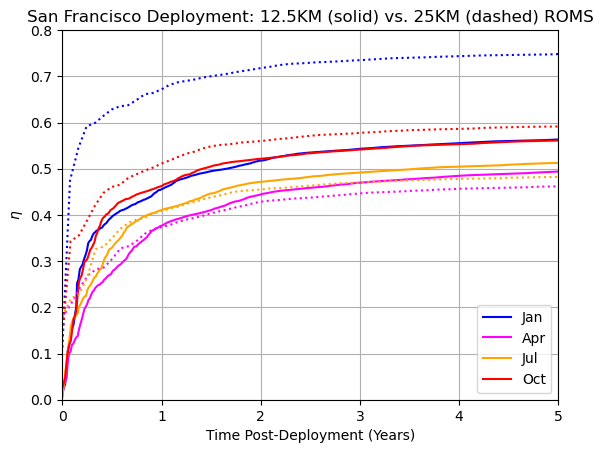

In [45]:
plt.plot((time-time[0])/86400/365,np.cumsum(np.nansum(np.nansum(flux_diff_Jan[0:]*86400*5*area.values,axis=1),axis=1))/total_alk_Jan,label='Jan',color='blue')
plt.plot((time[18:]-time[18])/86400/365,np.cumsum(np.nansum(np.nansum(flux_diff_Apr[18:]*86400*5*area.values,axis=1),axis=1))/total_alk_Apr,label='Apr',color='fuchsia')
plt.plot((time[36:]-time[36])/86400/365,np.cumsum(np.nansum(np.nansum(flux_diff_Jul[36:]*86400*5*area.values,axis=1),axis=1))/total_alk_Jul,label='Jul',color='orange')
plt.plot((time[54:]-time[54])/86400/365,np.cumsum(np.nansum(np.nansum(flux_diff_Oct[54:]*86400*5*area.values,axis=1),axis=1))/total_alk_Oct,label='Oct',color='red')

plt.legend()
plt.plot(f1,f2,':',label='Jan 25KM',color='blue')
plt.plot(f3,f4,':',label='Apr 25KM',color='fuchsia')
plt.plot(f5,f6,':',label='Jul 25KM',color='orange')
plt.plot(f7,f8,':',label='Oct 25KM',color='red')


plt.title('San Francisco Deployment: 12.5KM (solid) vs. 25KM (dashed) ROMS')
plt.grid(); plt.xlim([0,5]); plt.ylim([0,0.8]);
plt.xlabel('Time Post-Deployment (Years)'); plt.ylabel('$\eta$')

In [46]:
# plt.plot((time-time[0])/86400/365,np.nansum(np.nansum(DIC_diff_Jan[0:],axis=1),axis=1)/total_alk_Jan,label='Jan',color='blue')
# plt.plot((time[18:]-time[18])/86400/365,np.nansum(np.nansum(DIC_diff_Apr[18:],axis=1),axis=1)/total_alk_Apr,label='Apr',color='fuchsia')
# plt.plot((time[36:]-time[36])/86400/365,np.nansum(np.nansum(DIC_diff_Jul[36:],axis=1),axis=1)/total_alk_Jul,label='Jul',color='orange')
# plt.plot((time[54:]-time[54])/86400/365,np.nansum(np.nansum(DIC_diff_Oct[54:],axis=1),axis=1)/total_alk_Oct,label='Oct',color='red')
# plt.legend()
# plt.title('San Francisco Deployment: 25KM ROMS')
# #plt.grid(); plt.xlim([0,9]); plt.ylim([0,0.8]);
# plt.xlabel('Time Post-Deployment (Years)'); plt.ylabel('$\eta$')

In [47]:
t = np.array(range(14*12))


IRF_01 = np.nansum(np.nansum(DIC_diff_Jan[0:168],axis=1),axis=1)/np.nansum(np.nansum(ALK_diff_Jan[0:168],axis=1),axis=1)
IRF_04 = np.nansum(np.nansum(DIC_diff_Apr[3:171],axis=1),axis=1)/np.nansum(np.nansum(ALK_diff_Apr[3:171],axis=1),axis=1)
IRF_07 = np.nansum(np.nansum(DIC_diff_Jul[6:174],axis=1),axis=1)/np.nansum(np.nansum(ALK_diff_Jul[6:174],axis=1),axis=1)
IRF_10 = np.nansum(np.nansum(DIC_diff_Oct[9:177],axis=1),axis=1)/np.nansum(np.nansum(ALK_diff_Oct[9:177],axis=1),axis=1)

IRF_02 = IRF_01*(2/3) + IRF_04*(1/3)
IRF_03 = IRF_01*(1/3) + IRF_04*(2/3)
IRF_05 = IRF_04*(2/3) + IRF_07*(1/3)
IRF_06 = IRF_04*(1/3) + IRF_07*(2/3)
IRF_08 = IRF_07*(2/3) + IRF_10*(1/3)
IRF_09 = IRF_07*(1/3) + IRF_10*(2/3)
IRF_11 = IRF_10*(2/3) + IRF_01*(1/3)
IRF_12 = IRF_10*(1/3) + IRF_01*(2/3)

IRF_13 = IRF_01; IRF_25 = IRF_01; IRF_37 = IRF_01; IRF_49 = IRF_01;
IRF_14 = IRF_02; IRF_26 = IRF_02; IRF_38 = IRF_02; IRF_50 = IRF_02;
IRF_15 = IRF_03; IRF_27 = IRF_03; IRF_39 = IRF_03; IRF_51 = IRF_03;
IRF_16 = IRF_04; IRF_28 = IRF_04; IRF_40 = IRF_04; IRF_52 = IRF_04;
IRF_17 = IRF_05; IRF_29 = IRF_05; IRF_41 = IRF_05; IRF_53 = IRF_05;
IRF_18 = IRF_06; IRF_30 = IRF_06; IRF_42 = IRF_06; IRF_54 = IRF_06;
IRF_19 = IRF_07; IRF_31 = IRF_07; IRF_43 = IRF_07; IRF_55 = IRF_07;
IRF_20 = IRF_08; IRF_32 = IRF_08; IRF_44 = IRF_08; IRF_56 = IRF_08;
IRF_21 = IRF_09; IRF_33 = IRF_09; IRF_45 = IRF_09; IRF_57 = IRF_09;
IRF_22 = IRF_10; IRF_34 = IRF_10; IRF_46 = IRF_10; IRF_58 = IRF_10;
IRF_23 = IRF_11; IRF_35 = IRF_11; IRF_47 = IRF_11; IRF_59 = IRF_11;
IRF_24 = IRF_12; IRF_36 = IRF_12; IRF_48 = IRF_12; IRF_60 = IRF_12;

/glade/work/eyankovsky/conda-envs/mcdr/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/glade/work/eyankovsky/conda-envs/mcdr/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/glade/work/eyankovsky/conda-envs/mcdr/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


1
2
3
4
5
6
7
8
9
10
11
12


([<matplotlib.axis.XTick at 0x1544144bef90>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

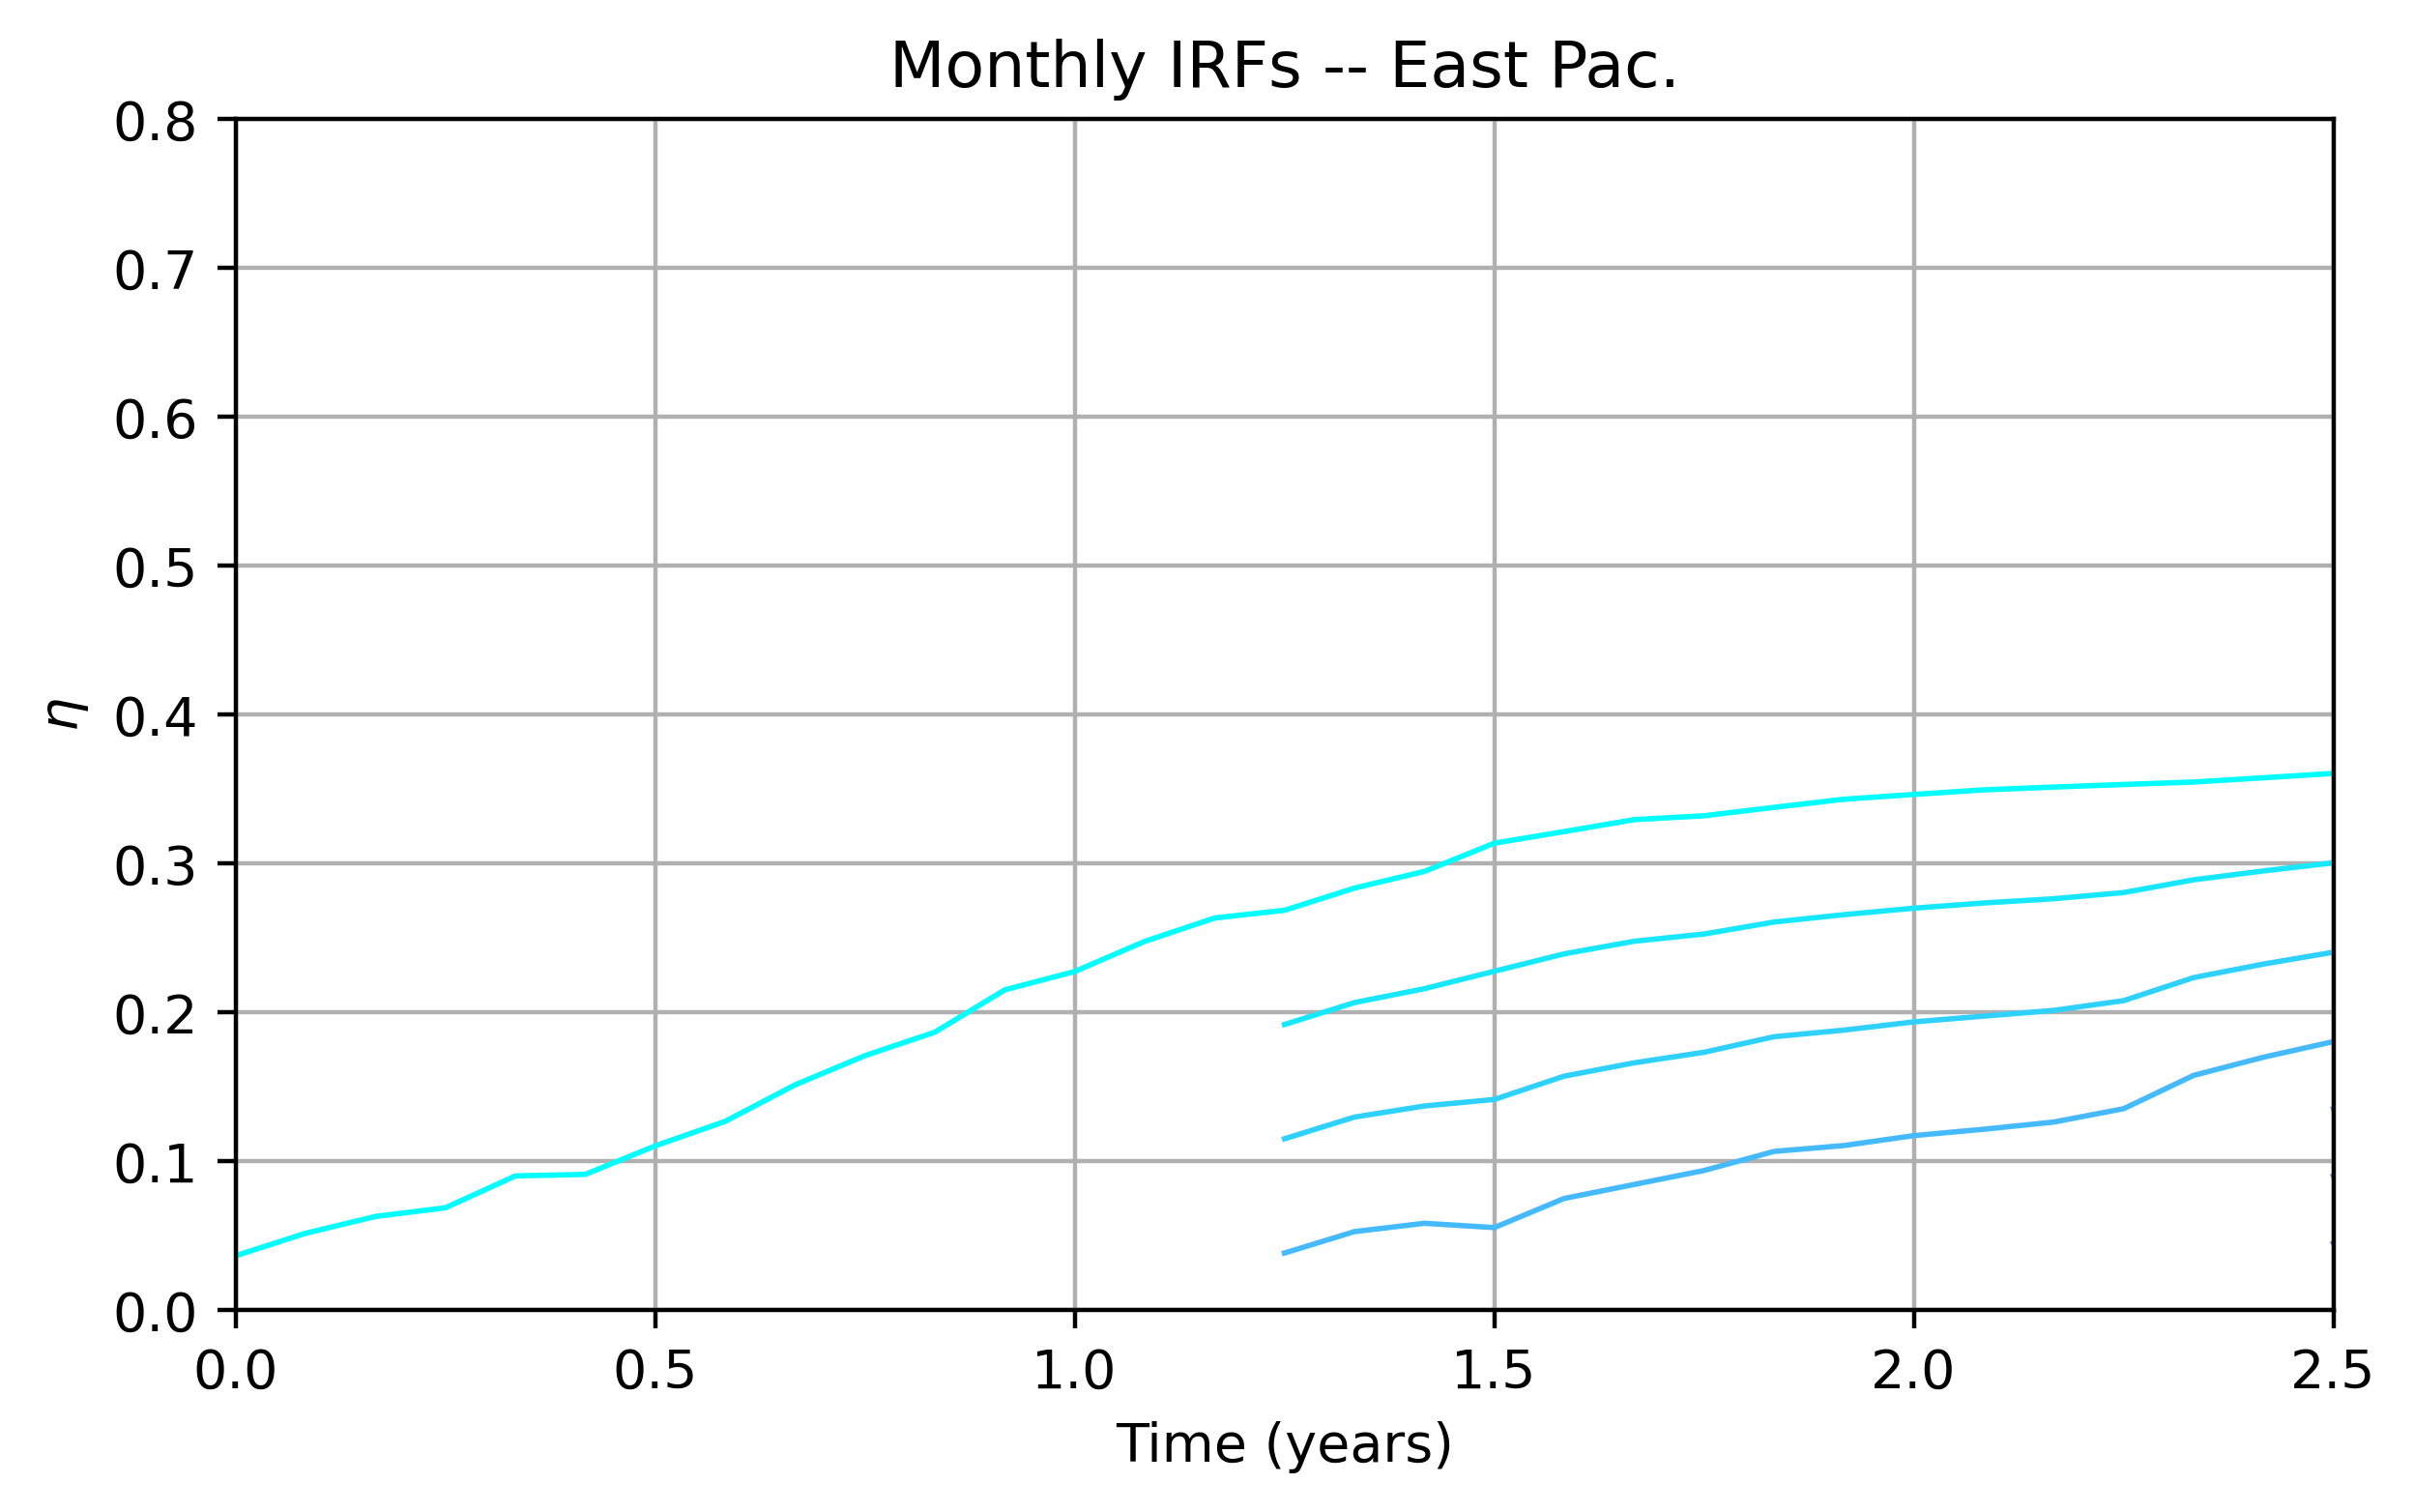

In [48]:
fig = plt.figure(figsize=(7,4),dpi=400)

color = iter(plt.cm.cool(np.linspace(0, 1, 12)))

   

for i in range(1,13):
    print(i)
    c = next(color)
    #print(globals()[f'IRF_{i:02d}'])
    plt.plot(t/12,globals()[f'IRF_{i:02d}'],label=f'IRF Month {i:02d}',c=c,linewidth=1)
#plt.legend()
plt.ylabel('$\eta$')
plt.xlabel('Time (years)')
plt.title('Monthly IRFs -- East Pac.')
#plt.plot([0, 190],[0.85,0.85])
plt.grid('on')
plt.xlim([0,2.5])
plt.ylim([0,.8])
plt.xticks(np.linspace(0,2.5,6))

In [49]:
fig = plt.figure(figsize=(7,4),dpi=400)

ALK_added_total = ((xr.open_dataset('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/ALK_forcing.nc').ALK[:]*86400*1e3/365)*area).sum(axis=1).sum(axis=1) #mol/day
ALK_added_total=ALK_added_total[0:180]; ALK_added_total[12:180]=0;
convolution_simple1 = np.convolve(ALK_added_total, IRF_01)

ALK_added_local = np.zeros(ALK_added_total.shape); ALK_added_local[0]=ALK_added_total[0]
convolution1    = np.zeros(ALK_added_total.shape);
for i in range(0,12):
    print(i)
    #ALk_added_local = np.zeros(ALk_added_total.shape); ALk_added_local[i]=ALk_added_total[i]
    convolution_local = np.convolve(ALK_added_local, globals()[f'IRF_{i+1:02d}'])
    convolution1[i:168] = convolution1[i:168] + convolution_local[0:168-i]

plt.plot(np.linspace(0,15,180),np.nansum(np.nansum(DIC_diff_1yr[0:180],axis=1),axis=1)/np.nansum(np.nansum(ALK_diff_1yr[0:180],axis=1),axis=1),label='1 year deployment',color='black')
plt.plot(np.linspace(0,15,180),convolution_simple1[0:180]/np.cumsum(ALK_added_total),'-.',label='January IRF prediction',color='coral')

plt.plot(np.linspace(0,15,180),convolution1/np.cumsum(ALK_added_total),label='Seasonal IRF prediction',color='coral')





plt.xlim([0,2.5]); plt.ylim([0,0.6])
plt.grid(); plt.legend(); plt.xlabel('Time (years)'); plt.ylabel('$\eta$')

ValueError: arguments without labels along dimension 'eta_rho' cannot be aligned because they have different dimension sizes: {162, 322}

<Figure size 2800x1600 with 0 Axes>

In [51]:
fig = plt.figure(figsize=(7,4),dpi=400)

ALK_added_total = ((xr.open_dataset('/glade/derecho/scratch/eyankovsky/EASTPAC25KM/ALK_forcing.nc').ALK[:]*86400*1e3/365)*area).sum(axis=1).sum(axis=1) #mol/day
ALK_added_total=ALK_added_total[0:180]; ALK_added_total[36:180]=0;
convolution_simple3 = np.convolve(ALK_added_total, IRF_01)

ALK_added_local = np.zeros(ALK_added_total.shape); ALK_added_local[0]=ALK_added_total[0]
convolution3    = np.zeros(ALK_added_total.shape);
for i in range(0,36):
    print(i)
    #ALk_added_local = np.zeros(ALk_added_total.shape); ALk_added_local[i]=ALk_added_total[i]
    convolution_local = np.convolve(ALK_added_local, globals()[f'IRF_{i+1:02d}'])
    convolution3[i:168] = convolution3[i:168] + convolution_local[0:168-i]

plt.plot(np.linspace(0,15,180),np.nansum(np.nansum(DIC_diff_3yr[0:180],axis=1),axis=1)/np.nansum(np.nansum(ALK_diff_3yr[0:180],axis=1),axis=1),label='3 year deployment',color='black')
plt.plot(np.linspace(0,15,180),convolution_simple3[0:180]/np.cumsum(ALK_added_total),'-.',label='January IRF prediction',color='darkcyan')
plt.plot(np.linspace(0,15,180),convolution3/np.cumsum(ALK_added_total),label='Seasonal IRF prediction',color='darkcyan')
plt.xlim([0,4.5])
plt.grid(); plt.legend()

ValueError: arguments without labels along dimension 'eta_rho' cannot be aligned because they have different dimension sizes: {162, 322}

<Figure size 2800x1600 with 0 Axes>

In [ ]:
IRF_10[0:60]

In [ ]:
len(infiles_1YR)

In [ ]:
np.nanmax(mask)

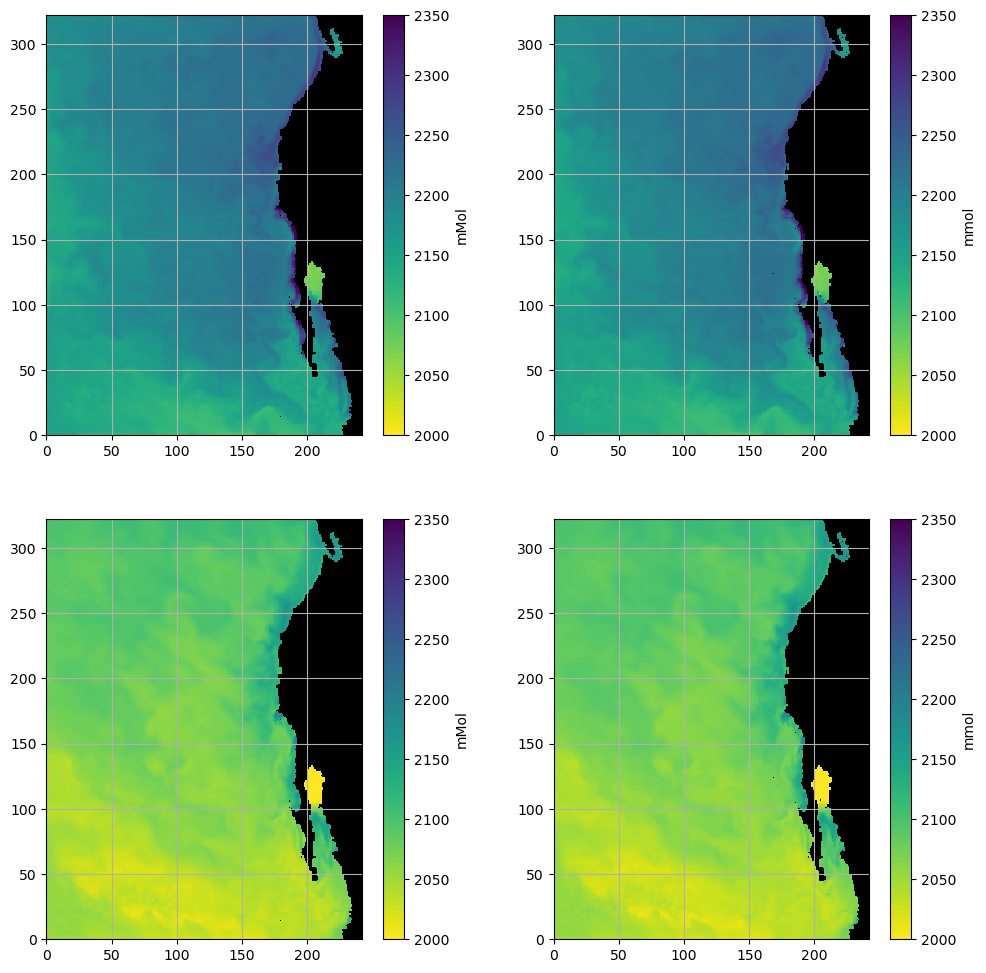

In [52]:
depth = np.ma.array(grd.mask_rho)#, mask=grd.hraw >0)
mask= grd.mask_rho.where(grd.mask_rho>0)

fig = plt.figure(figsize=(12,12),dpi=100)

i = 647
ALK_forced_1yr = xr.open_dataset(infiles_1YR[i])['Alk'][1,-1,:,:]
DIC_forced_1yr = xr.open_dataset(infiles_1YR[i])['DIC'][1,-1,:,:]  
ALK_forced_1yr_IC = xr.open_dataset(infiles_1YR[0])['Alk'][1,-1,:,:]
DIC_forced_1yr_IC = xr.open_dataset(infiles_1YR[0])['DIC'][1,-1,:,:]  

ALK_unforced = xr.open_dataset(infiles_ctl[i])['Alk'][1,-1,:,:]
DIC_unforced = xr.open_dataset(infiles_ctl[i])['DIC'][1,-1,:,:]
ALK_unforced_IC = xr.open_dataset(infiles_ctl[0])['Alk'][1,-1,:,:]
DIC_unforced_IC = xr.open_dataset(infiles_ctl[0])['DIC'][1,-1,:,:]
# ALK_surf_diff =  ALK_forced_1yr-ALK_unforced
# DIC_surf_diff =  DIC_forced_1yr-DIC_unforced

plt.subplot(2,2,1)
plt.pcolor(depth,cmap='bone')
#plt.pcolor((ALK_forced_1yr *mask),vmin=2250,vmax=2450)
plt.pcolor((DIC_unforced *mask),vmin=2000,vmax=2350,cmap='viridis_r')
plt.colorbar(label='mMol')
plt.gca().set_aspect('equal')
plt.grid()

plt.subplot(2,2,2)
plt.pcolor(depth,cmap='bone')
plt.pcolor((DIC_forced_1yr *mask),vmin=2000,vmax=2350,cmap='viridis_r')
plt.colorbar(label='mmol')
plt.gca().set_aspect('equal')
plt.grid()

plt.subplot(2,2,3)
plt.pcolor(depth,cmap='bone')
plt.pcolor((DIC_unforced_IC *mask),vmin=2000,vmax=2350,cmap='viridis_r')
#plt.pcolor((ALK_forced_1yr *mask),vmin=2250,vmax=2450)
#plt.pcolor((ALK_unforced *mask),vmin=2250,vmax=2450)
plt.colorbar(label='mMol')
plt.gca().set_aspect('equal')
plt.grid()

plt.subplot(2,2,4)
plt.pcolor(depth,cmap='bone')
plt.pcolor((DIC_forced_1yr_IC *mask),vmin=2000,vmax=2350,cmap='viridis_r')

#plt.pcolor((ALK_forced_1yr *mask),vmin=2250,vmax=2450)
plt.colorbar(label='mmol')
plt.gca().set_aspect('equal')
plt.grid()

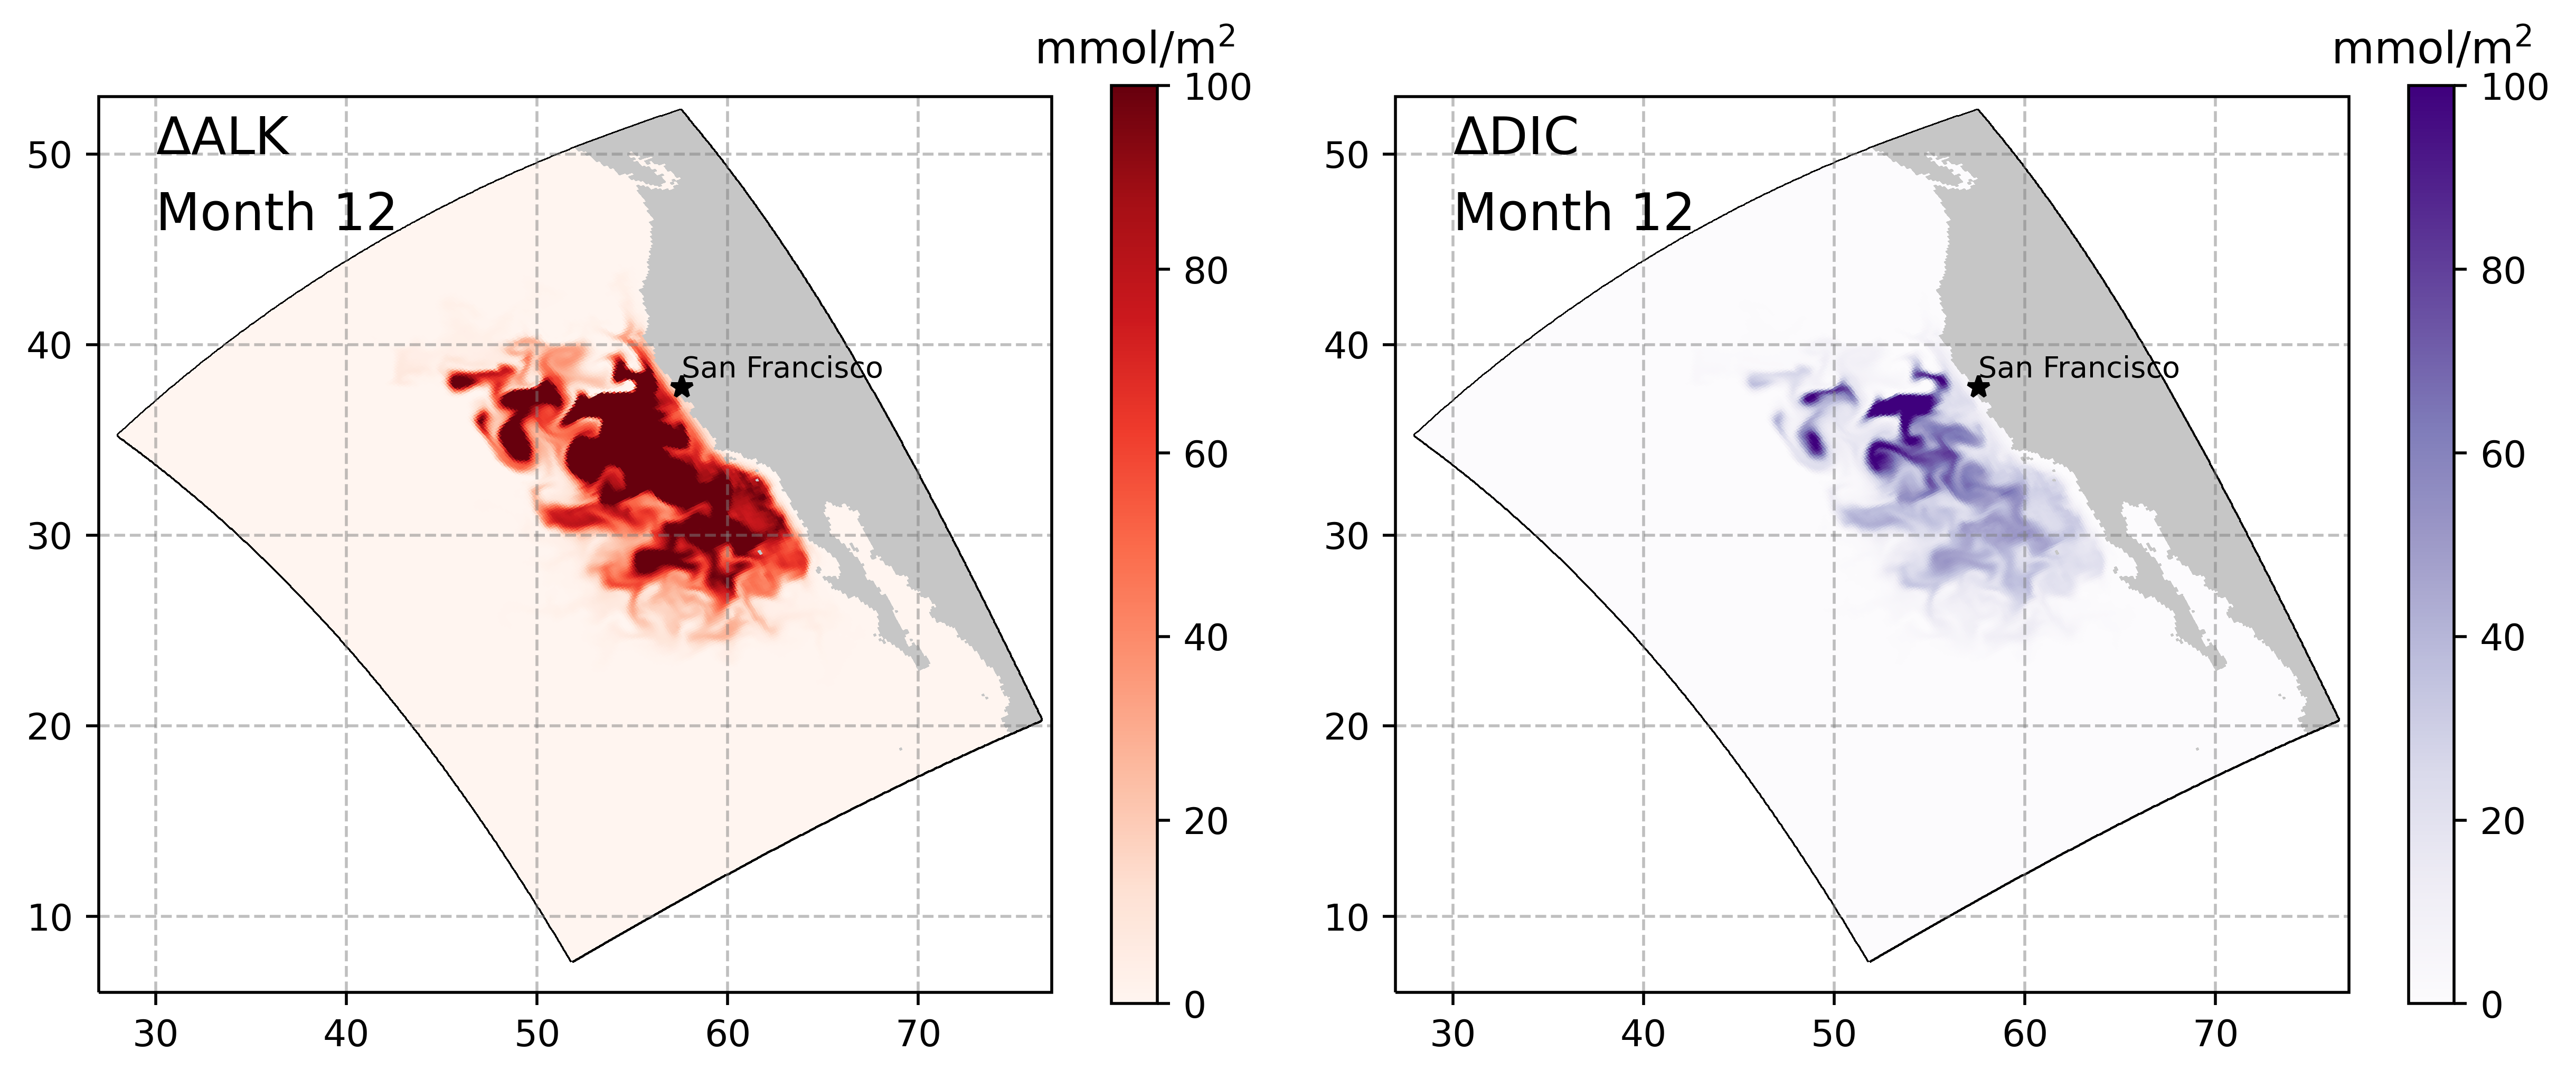

In [53]:
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
fig = plt.figure(figsize=(10,5),dpi=500)
ax = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())


ii=72


ax.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.lat_rho*0,transform=ccrs.PlateCarree(), color='k');

sca = ax.pcolormesh(grd.lon_rho-180,
                grd.lat_rho,
                ALK_diff_3yr[ii]*mask/area,
                transform=ccrs.PlateCarree(),
                vmin=0,vmax=100,cmap='Reds');
cb = fig.colorbar(sca, ax=ax, shrink=0.74)

sca = ax.pcolormesh(grd.lon_rho-180,
                grd.lat_rho,
                grd.mask_rho.where(grd.mask_rho<1),
                transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=2);



cb.ax.set_title('mmol/m$^2$')
true_lat = 37.78
true_lon = -122.43+180
plt.plot(true_lon,true_lat,'*',color='k',markersize=6,transform=ccrs.PlateCarree())
plt.text(true_lon,true_lat+.5,'San Francisco',fontsize=8,color='k',transform=ccrs.PlateCarree())
plt.text(30,50,'$\Delta$ALK', fontsize=14)

plt.text(30,46,'Month %i'%np.round(((time[ii]/86400)-731)/30.5), fontsize=14)


ax.set_extent([27, 77, 6, 53], ccrs.PlateCarree())
ax.set_xticks(np.arange(30, 80, 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(10, 60, 10), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter() 
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                   color='gray', alpha=0.5, linestyle='--')



ax = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.lat_rho*0,transform=ccrs.PlateCarree(), color='k');

sca = ax.pcolormesh(grd.lon_rho-180,
                grd.lat_rho,
                DIC_diff_3yr[ii]*mask/area,
                transform=ccrs.PlateCarree(),
                vmin=0,vmax=100,cmap='Purples');
cb = fig.colorbar(sca, ax=ax, shrink=0.74)

sca = ax.pcolormesh(grd.lon_rho-180,
                grd.lat_rho,
                grd.mask_rho.where(grd.mask_rho<1),
                transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=2);


cb.ax.set_title('mmol/m$^2$')
true_lat = 37.78
true_lon = -122.43+180
plt.plot(true_lon,true_lat,'*',color='k',markersize=6,transform=ccrs.PlateCarree())
plt.text(true_lon,true_lat+.5,'San Francisco',fontsize=8,color='k',transform=ccrs.PlateCarree())
plt.text(30,50,'$\Delta$DIC', fontsize=14)

plt.text(30,46,'Month %i'%np.round(((time[ii]/86400)-731)/30.5), fontsize=14)


ax.set_extent([27, 77, 6, 53], ccrs.PlateCarree())
ax.set_xticks(np.arange(30, 80, 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(10, 60, 10), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter() 
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                   color='gray', alpha=0.5, linestyle='--')
plt.tight_layout()


/glade/u/home/eyankovsky/.local/lib/python3.7/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/glade/u/home/eyankovsky/.local/lib/python3.7/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/glade/work/eyankovsky/conda-envs/mcdr/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("cubehelix_r").copy()


Text(0.5, 1.07, '12.5 KM Resolution')

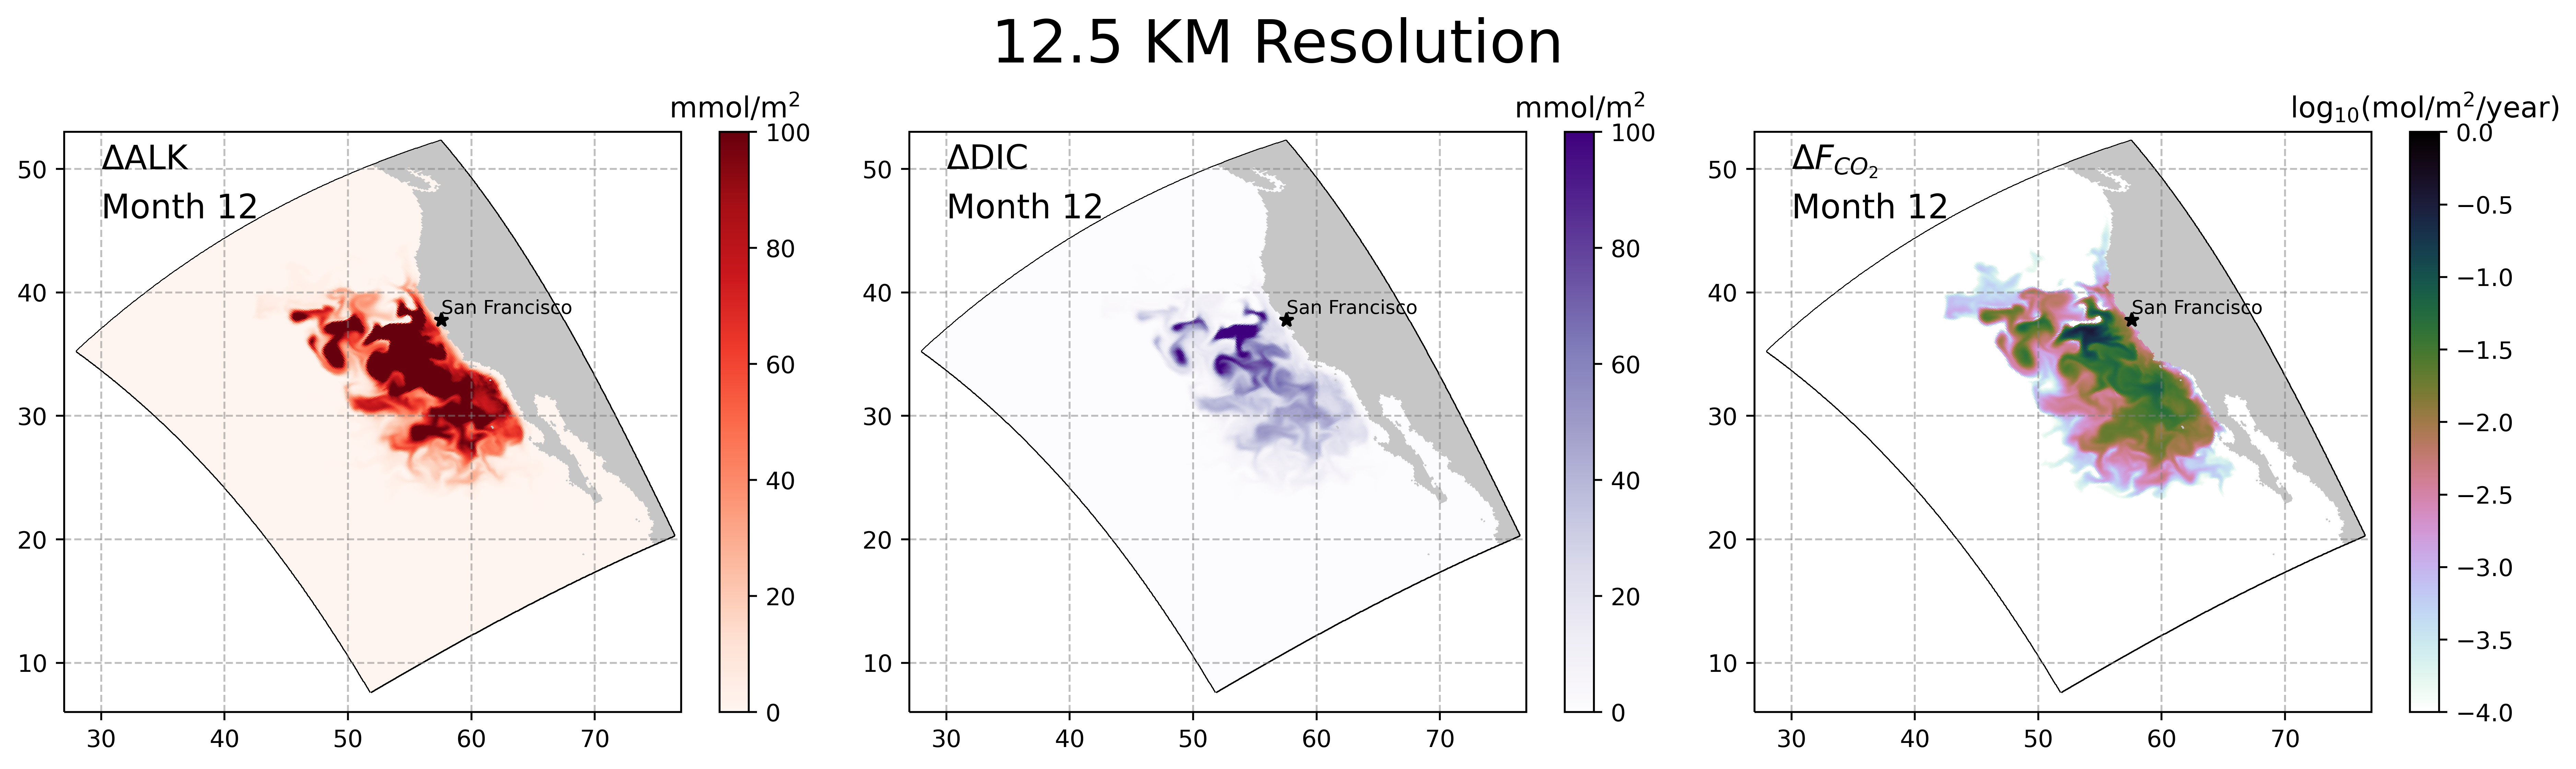

In [54]:
ii=72
cbarmax = 100 #upper colorbar limit!
true_lat = 37.78
true_lon = -122.43+180


fig = plt.figure(figsize=(15,4),dpi=500)
ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())


ax1.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.lat_rho*0,transform=ccrs.PlateCarree(), color='k');
sca = ax1.pcolormesh(grd.lon_rho-180, grd.lat_rho, ALK_diff_1yr[ii]*mask/area, transform=ccrs.PlateCarree(),
                vmin=0,vmax=cbarmax,cmap='Reds');
cb = fig.colorbar(sca, ax=ax1); cb.ax.set_title('mmol/m$^2$')
sca = ax1.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.mask_rho.where(grd.mask_rho<1), transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=2);

ax1.plot(true_lon,true_lat,'*',color='k',markersize=6,transform=ccrs.PlateCarree())
ax1.text(true_lon,true_lat+.5,'San Francisco',fontsize=8,color='k',transform=ccrs.PlateCarree())
ax1.text(30,50,'$\Delta$ALK', fontsize=14)
ax1.text(30,46,'Month %i'%np.round(((time[ii]/86400)-731)/30.5), fontsize=14)
ax1.set_extent([27, 77, 6, 53], ccrs.PlateCarree())
ax1.set_xticks(np.arange(30, 80, 10), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(10, 60, 10), crs=ccrs.PlateCarree())
ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                   color='gray', alpha=0.5, linestyle='--')



ax2.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.lat_rho*0,transform=ccrs.PlateCarree(), color='k');
sca = ax2.pcolormesh(grd.lon_rho-180, grd.lat_rho, DIC_diff_1yr[ii]*mask/area, transform=ccrs.PlateCarree(),
                vmin=0,vmax=cbarmax,cmap='Purples'); 
cb = fig.colorbar(sca, ax=ax2)
sca = ax2.pcolormesh(grd.lon_rho-180,grd.lat_rho, grd.mask_rho.where(grd.mask_rho<1), transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=2);
cb.ax.set_title('mmol/m$^2$')
ax2.plot(true_lon,true_lat,'*',color='k',markersize=6,transform=ccrs.PlateCarree())
ax2.text(true_lon,true_lat+.5,'San Francisco',fontsize=8,color='k',transform=ccrs.PlateCarree())
ax2.text(30,50,'$\Delta$DIC', fontsize=14)
ax2.text(30,46,'Month %i'%np.round(((time[ii]/86400)-731)/30.5), fontsize=14)
ax2.set_extent([27, 77, 6, 53], ccrs.PlateCarree())
ax2.set_xticks(np.arange(30, 80, 10), crs=ccrs.PlateCarree())
ax2.set_yticks(np.arange(10, 60, 10), crs=ccrs.PlateCarree())
ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                   color='gray', alpha=0.5, linestyle='--')


ax3.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.lat_rho*0,transform=ccrs.PlateCarree(), color='k');
flux_plot = np.log10(flux_diff_1yr[ii]*mask*86400*365/1000); #mol/m^2/year
sca = ax3.pcolormesh(grd.lon_rho-180,
                grd.lat_rho,
                flux_plot,vmin=-4,vmax=0,
                transform=ccrs.PlateCarree(),
                cmap='cubehelix_r');#
sca.cmap.set_over("black"); sca.cmap.set_under("white"); sca.cmap.set_bad('white')
cb = fig.colorbar(sca, ax=ax3)
sca = ax3.pcolormesh(grd.lon_rho-180,
                grd.lat_rho,
                grd.mask_rho.where(grd.mask_rho<1),
                transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=2);
cb.ax.set_title('log$_{10}$(mol/m$^2$/year)')
plt.plot(true_lon,true_lat,'*',color='k',markersize=6,transform=ccrs.PlateCarree())
plt.text(true_lon,true_lat+.5,'San Francisco',fontsize=8,color='k',transform=ccrs.PlateCarree())
plt.text(30,50,'$\Delta F_{CO_2}$', fontsize=14)
plt.text(30,46,'Month %i'%np.round(((time[ii]/86400)-731)/30.5), fontsize=14)
ax3.set_extent([27, 77, 6, 53], ccrs.PlateCarree())
ax3.set_xticks(np.arange(30, 80, 10), crs=ccrs.PlateCarree())
ax3.set_yticks(np.arange(10, 60, 10), crs=ccrs.PlateCarree())

ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                   color='gray', alpha=0.5, linestyle='--')
plt.tight_layout()
plt.suptitle('12.5 KM Resolution',y=1.07,fontsize=25)


In [55]:
print('done')

done


NameError: name 'int_flux' is not defined

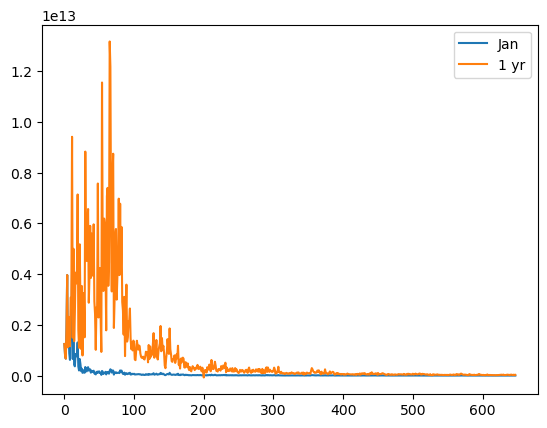

In [56]:
int_fluxJan = np.nansum(np.nansum(flux_diff_Jan*area.values,axis=1),axis=1)*30.42*86400
int_flux1yr = np.nansum(np.nansum(flux_diff_1yr*area.values,axis=1),axis=1)*30.42*86400
int_flux3yr = np.nansum(np.nansum(flux_diff_3yr*area.values,axis=1),axis=1)*30.42*86400

#int_flux = flux_diff_1yr#*area
#int_flux.shape
plt.plot(int_fluxJan,label='Jan')
plt.plot(int_flux1yr,label='1 yr')
#plt.plot(int_flux3yr,label='3 yr')
plt.legend()
int_flux.shape

In [63]:

for ii in range(0,648):  #len(bgc_1YR)
    true_lat = 37.78
    true_lon = -122.43+180
    fig = plt.figure(figsize=(15,4),dpi=200)

    ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())
    ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.PlateCarree())
    ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())




    ax1.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.lat_rho*0,transform=ccrs.PlateCarree(), color='k');
    sca = ax1.pcolormesh(grd.lon_rho-180, grd.lat_rho, ALK_diff_1yr[ii]*mask/area, transform=ccrs.PlateCarree(),
                vmin=0,vmax=150,cmap='Reds');
    cb = fig.colorbar(sca, ax=ax1); cb.ax.set_title('mmol/m$^2$')
    sca = ax1.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.mask_rho.where(grd.mask_rho<1), transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=2);

    ax1.plot(true_lon,true_lat,'*',color='k',markersize=6,transform=ccrs.PlateCarree())
    ax1.text(true_lon,true_lat+.5,'San Francisco',fontsize=8,color='k',transform=ccrs.PlateCarree())
    ax1.text(30,50,'$\Delta$ALK', fontsize=14)
    ax1.text(30,46,'Month %i'%np.round(((time[ii]/86400)-731)/30.5), fontsize=14)
    ax1.set_extent([27, 77, 6, 53], ccrs.PlateCarree())
    ax1.set_xticks(np.arange(30, 80, 10), crs=ccrs.PlateCarree())
    ax1.set_yticks(np.arange(10, 60, 10), crs=ccrs.PlateCarree())
    ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                   color='gray', alpha=0.5, linestyle='--')



    ax2.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.lat_rho*0,transform=ccrs.PlateCarree(), color='k');
    sca = ax2.pcolormesh(grd.lon_rho-180, grd.lat_rho, DIC_diff_1yr[ii]*mask/area, transform=ccrs.PlateCarree(),
                vmin=0,vmax=150,cmap='Purples'); 
    cb = fig.colorbar(sca, ax=ax2)
    sca = ax2.pcolormesh(grd.lon_rho-180,grd.lat_rho, grd.mask_rho.where(grd.mask_rho<1), transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=2);
    cb.ax.set_title('mmol/m$^2$')
    ax2.plot(true_lon,true_lat,'*',color='k',markersize=6,transform=ccrs.PlateCarree())
    ax2.text(true_lon,true_lat+.5,'San Francisco',fontsize=8,color='k',transform=ccrs.PlateCarree())
    ax2.text(30,50,'$\Delta$DIC', fontsize=14)
    ax2.text(30,46,'Month %i'%np.round(((time[ii]/86400)-731)/30.5), fontsize=14)
    ax2.set_extent([27, 77, 6, 53], ccrs.PlateCarree())
    ax2.set_xticks(np.arange(30, 80, 10), crs=ccrs.PlateCarree())
    ax2.set_yticks(np.arange(10, 60, 10), crs=ccrs.PlateCarree())
    ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                   color='gray', alpha=0.5, linestyle='--')


    ax3.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.lat_rho*0,transform=ccrs.PlateCarree(), color='k');
    flux_plot = (flux_diff_1yr[ii]*mask*86400*365/1000); #mol/m^2/year
    sca = ax3.pcolormesh(grd.lon_rho-180,
                grd.lat_rho,
                flux_plot,vmin=0,vmax=0.01,
                transform=ccrs.PlateCarree(),
                cmap='cubehelix_r');#
    sca.cmap.set_over("black"); sca.cmap.set_under("white"); sca.cmap.set_bad('white')
    cb = fig.colorbar(sca, ax=ax3)
    sca = ax3.pcolormesh(grd.lon_rho-180,
                grd.lat_rho,
                grd.mask_rho.where(grd.mask_rho<1),
                transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=2);
    cb.ax.set_title('(mol/m$^2$/year)')
    plt.plot(true_lon,true_lat,'*',color='k',markersize=6,transform=ccrs.PlateCarree())
    plt.text(true_lon,true_lat+.5,'San Francisco',fontsize=8,color='k',transform=ccrs.PlateCarree())
    plt.text(30,50,'$\Delta F_{CO_2}$', fontsize=14)
    plt.text(30,46,'Month %i'%np.round(((time[ii]/86400)-731)/30.5), fontsize=14)
    ax3.set_extent([27, 77, 6, 53], ccrs.PlateCarree())
    ax3.set_xticks(np.arange(30, 80, 10), crs=ccrs.PlateCarree())
    ax3.set_yticks(np.arange(10, 60, 10), crs=ccrs.PlateCarree())

    ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                   color='gray', alpha=0.5, linestyle='--')
    plt.tight_layout()
    plt.savefig("vidfiles/%03d.png" % ii,dpi=200)
    plt.clf()

/glade/work/eyankovsky/conda-envs/mcdr/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("cubehelix_r").copy()
/glade/work/eyankovsky/conda-envs/mcdr/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("cubehelix_r").copy()
/glade/work/eyankovsky/conda-envs/mcdr/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

<Figure size 3000x800 with 0 Axes>

In [ ]:
# # t0 = xr.open_dataset(init_file).ocean_time
# # tf = xr.open_dataset(infiles[0]).ocean_time[1]
# # (tf-t0)/86400

# time_diff = 31.0*86400 #January
# total_alk = (xr.open_dataset('ALK_forcing.nc').ALK[1,:]*time_diff)*area
# total_alk = np.nansum(total_alk)


# #TO CHECK what percentage of alk we still have in the domain
# np.nansum(ALK_diff[1])/total_alk


In [ ]:
for ii in range(0,648):  #len(bgc_1YR)
    true_lat = 37.78
    true_lon = -122.43+180
    fig = plt.figure(figsize=(10.3,4),dpi=300)


    ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
    ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())

    ALK_ini = xr.open_dataset(infiles_ctl[0])['Alk'][1,-1,:,:]
    ALK_fin = xr.open_dataset(infiles_ctl[647])['Alk'][1,-1,:,:]
    ALK_forced_1yr = xr.open_dataset(infiles_1YR[ii])['Alk'][1,-1,:,:]
    DIC_forced_1yr = xr.open_dataset(infiles_1YR[ii])['DIC'][1,-1,:,:]  
    ALK_unforced = xr.open_dataset(infiles_ctl[ii])['Alk'][1,-1,:,:]
    DIC_unforced = xr.open_dataset(infiles_ctl[ii])['DIC'][1,-1,:,:]
    ALK_surf_diff =  ALK_forced_1yr-ALK_unforced
    DIC_surf_diff =  DIC_forced_1yr-DIC_unforced
#    ALK_forced_ws_1yr = (ALK_forced_1yr*H).sum(axis=0)     #mmol/m2
#    DIC_forced_ws_1yr = (DIC_forced_1yr*H).sum(axis=0)    #mmol/m2

    bias = (ALK_fin-ALK_ini)*(ii/647)

    ax1.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.lat_rho*0,transform=ccrs.PlateCarree(), color='k');
    sca = ax1.pcolormesh(grd.lon_rho-180, grd.lat_rho,(ALK_forced_1yr-bias)*mask, transform=ccrs.PlateCarree(),
                cmap='inferno_r',vmin=2250,vmax=2400);
    cb = fig.colorbar(sca, ax=ax1); cb.ax.set_title('mmol/m$^3$')
    sca = ax1.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.mask_rho.where(grd.mask_rho<1), transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=2);
    ax1.contour(grd.lon_rho-180, grd.lat_rho, ALK_surf_diff, levels=np.linspace(.01,5,20), linewidths=.4, cmap = 'binary', transform=ccrs.PlateCarree());

    ax1.plot(true_lon,true_lat,'*',color='k',markersize=6,transform=ccrs.PlateCarree())
    ax1.text(true_lon,true_lat+.5,'San Francisco',fontsize=8,color='k',transform=ccrs.PlateCarree())
    ax1.text(30,50,'Surface ALK', fontsize=14)
    ax1.text(30,46,'Month %i'%np.round(((time[ii]/86400)-731)/30.5), fontsize=14)
    ax1.set_extent([27, 77, 6, 53], ccrs.PlateCarree())
    ax1.set_xticks(np.arange(30, 80, 10), crs=ccrs.PlateCarree())
    ax1.set_yticks(np.arange(10, 60, 10), crs=ccrs.PlateCarree())
    ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                   color='gray', alpha=0.5, linestyle='--')



    ax2.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.lat_rho*0,transform=ccrs.PlateCarree(), color='k');
    sca = ax2.pcolormesh(grd.lon_rho-180, grd.lat_rho, DIC_forced_1yr*mask, transform=ccrs.PlateCarree(),
                cmap='viridis_r',vmin=2000,vmax=2350); 
    cb = fig.colorbar(sca, ax=ax2)
    sca = ax2.pcolormesh(grd.lon_rho-180,grd.lat_rho, grd.mask_rho.where(grd.mask_rho<1), transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=2);
    ax2.contour(grd.lon_rho-180, grd.lat_rho, DIC_surf_diff, levels=np.linspace(.01,5,20), linewidths=.4, cmap = 'binary', transform=ccrs.PlateCarree());

    cb.ax.set_title('mmol/m$^3$')
    ax2.plot(true_lon,true_lat,'*',color='k',markersize=6,transform=ccrs.PlateCarree())
    ax2.text(true_lon,true_lat+.5,'San Francisco',fontsize=8,color='k',transform=ccrs.PlateCarree())
    ax2.text(30,50,'Surface DIC', fontsize=14)
    ax2.text(30,46,'Month %i'%np.round(((time[ii]/86400)-731)/30.5), fontsize=14)
    ax2.set_extent([27, 77, 6, 53], ccrs.PlateCarree())
    ax2.set_xticks(np.arange(30, 80, 10), crs=ccrs.PlateCarree())
    ax2.set_yticks(np.arange(10, 60, 10), crs=ccrs.PlateCarree())
    ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                   color='gray', alpha=0.5, linestyle='--')



    plt.tight_layout()
    plt.savefig("ALK_hr/%03d.png" % ii,dpi=300)
    plt.clf()

/glade/work/eyankovsky/conda-envs/mcdr/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


In [ ]:
for ii in range(0,648):  #len(bgc_1YR)
    true_lat = 37.78
    true_lon = -122.43+180
    fig = plt.figure(figsize=(10.3,4),dpi=500)

    ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
    ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())

    ALK_forced_1yr = xr.open_dataset(infiles_1YR[ii])['Alk'][1,-1,:,:]
    DIC_forced_1yr = xr.open_dataset(infiles_1YR[ii])['DIC'][1,-1,:,:]  
    ALK_unforced = xr.open_dataset(infiles_ctl[ii])['Alk'][1,-1,:,:]
    DIC_unforced = xr.open_dataset(infiles_ctl[ii])['DIC'][1,-1,:,:]
    ALK_surf_diff =  ALK_forced_1yr-ALK_unforced
    DIC_surf_diff =  DIC_forced_1yr-DIC_unforced
#    ALK_forced_ws_1yr = (ALK_forced_1yr*H).sum(axis=0)     #mmol/m2
#    DIC_forced_ws_1yr = (DIC_forced_1yr*H).sum(axis=0)    #mmol/m2



    ax1.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.lat_rho*0,transform=ccrs.PlateCarree(), color='k');
    sca = ax1.pcolormesh(grd.lon_rho-180, grd.lat_rho,ALK_forced_1yr*mask, transform=ccrs.PlateCarree(),
                cmap='inferno_r',vmin=2250,vmax=2500);
    cb = fig.colorbar(sca, ax=ax1); cb.ax.set_title('mmol/m$^3$')
    sca = ax1.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.mask_rho.where(grd.mask_rho<1), transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=2);
    ax1.contour(grd.lon_rho-180, grd.lat_rho, ALK_surf_diff, levels=np.linspace(.01,5,20), linewidths=.5, cmap = 'binary', transform=ccrs.PlateCarree());

    ax1.plot(true_lon,true_lat,'*',color='k',markersize=6,transform=ccrs.PlateCarree())
    ax1.text(true_lon,true_lat+.5,'San Francisco',fontsize=8,color='k',transform=ccrs.PlateCarree())
    ax1.text(30,50,'Surface ALK', fontsize=14)
    ax1.text(30,46,'Month %i'%np.round(((time[ii]/86400)-731)/30.5), fontsize=14)
    ax1.set_extent([27, 77, 6, 53], ccrs.PlateCarree())
    ax1.set_xticks(np.arange(30, 80, 10), crs=ccrs.PlateCarree())
    ax1.set_yticks(np.arange(10, 60, 10), crs=ccrs.PlateCarree())
    ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                   color='gray', alpha=0.5, linestyle='--')



    ax2.pcolormesh(grd.lon_rho-180,grd.lat_rho,grd.lat_rho*0,transform=ccrs.PlateCarree(), color='k');
    sca = ax2.pcolormesh(grd.lon_rho-180, grd.lat_rho, DIC_forced_1yr*mask, transform=ccrs.PlateCarree(),
                cmap='viridis_r',vmin=2000,vmax=2350); 
    cb = fig.colorbar(sca, ax=ax2)
    sca = ax2.pcolormesh(grd.lon_rho-180,grd.lat_rho, grd.mask_rho.where(grd.mask_rho<1), transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=2);
    ax2.contour(grd.lon_rho-180, grd.lat_rho, DIC_surf_diff, levels=np.linspace(.01,5,20), linewidths=.4, cmap = 'binary', transform=ccrs.PlateCarree());

    cb.ax.set_title('mmol/m$^3$')
    ax2.plot(true_lon,true_lat,'*',color='k',markersize=6,transform=ccrs.PlateCarree())
    ax2.text(true_lon,true_lat+.5,'San Francisco',fontsize=8,color='k',transform=ccrs.PlateCarree())
    ax2.text(30,50,'Surface DIC', fontsize=14)
    ax2.text(30,46,'Month %i'%np.round(((time[ii]/86400)-731)/30.5), fontsize=14)
    ax2.set_extent([27, 77, 6, 53], ccrs.PlateCarree())
    ax2.set_xticks(np.arange(30, 80, 10), crs=ccrs.PlateCarree())
    ax2.set_yticks(np.arange(10, 60, 10), crs=ccrs.PlateCarree())
    ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                   color='gray', alpha=0.5, linestyle='--')


    plt.tight_layout()
    plt.savefig("ALK_hr/%03d.png" % ii,dpi=500)
    plt.clf()